# LED Data: Feb 15, 2023
## Import the libraries

In [1]:
import sys,os
import time 
import h5py

import numpy as np
import pandas as pd

# import matplotlib
import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches

from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.special import expit

sys.path.append('/home/nexus-admin/NEXUS_RF/BackendTools')
import PyMKID_USRP_functions as PUf
import PyMKID_resolution_functions as Prf
import TimestreamHelperFunctions as Thf
import MB_equations as MBe
# import MB_analysis as MBa

In [2]:
def fit_samples_to_gauss_unbinned(samples):
    def fit_cdf(x, mu, sig):
        return norm.cdf(x, loc=mu, scale=sig)
    
    pGuess = (np.mean(samples), np.std(samples))
    
    xdata = np.sort(samples)
    ydata = np.array([ float(len(xdata[xdata <= xdata[i]])) for i in np.arange(len(xdata))]) / float(len(xdata))
    
    popt, pcov = curve_fit(fit_cdf, xdata, ydata, p0=pGuess)
    perr = np.sqrt(np.diag(pcov))
    
    return popt, perr, pGuess

In [3]:
## MB Results come from fitting a temperature scan at a specified RF power
use_nexus_MBvals = False

if use_nexus_MBvals:
    ## As measured in NEXUS
    MB_fit_vals = np.array([4.24216+9.75e-6, 
                            0.177  ,
                            0.0125 ,
                            4.1e7  ]) ## [ F0 [GHz] , Delta [meV] , alpha , Qi0 ]
else:
    ## As measured on Caltech sister device (https://arxiv.org/pdf/2111.08064.pdf)
    MB_fit_vals = np.array([4.24201000, 
                            0.184     ,
                            0.03801   ,
                            4.05538e5 ]) ## [ F0 [GHz] , Delta [meV] , alpha , Qi0 ]
    
## How much attenuation is in the lines before the chip
line_atten_dB = 56.5

## Gather the files

In [4]:
datapath = '/data/USRP_Laser_Data'
series   = "20230215_101743"

sum_file, dly_file, vna_file, nse_files, led_files = Thf.GetFiles(series, 
                                                        base_path=datapath,
                                                        sep_noise_laser=True,
                                                        verbose=False)

In [5]:
for f in nse_files:
    print(f)

/data/USRP_Laser_Data/20230215/20230215_101743/USRP_Noise_20230215_101743_delta0.h5
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_Noise_20230215_101743_delta0_11.h5
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_Noise_20230215_101743_delta0_14.h5
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_Noise_20230215_101743_delta0_2.h5
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_Noise_20230215_101743_delta0_5.h5
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_Noise_20230215_101743_delta0_8.h5


## Load the summary file

In [6]:
md, charFs, charZs = Thf.UnpackSummary(sum_file, verbose=False)
rf_power = md['power'] + md['tx_gain']
print("RF Power at USRP:", rf_power, "dBm")

for i in np.arange(len(nse_files)):
    print(nse_files[i].split("/")[-1].split(".")[0],charZs[i])
    print(charFs[i])

RF Power at USRP: -16 dBm
USRP_Noise_20230215_101743_delta0 [0.13392927+0.06659739j 0.13341133+0.07298083j 0.13270856+0.08030111j]
[4241.97901  4241.979857 4241.980704]
USRP_Noise_20230215_101743_delta0_11 [0.13429799+0.06697518j 0.13330332+0.07371326j 0.13196758+0.08167826j]
[4241.97901  4241.979857 4241.980704]
USRP_Noise_20230215_101743_delta0_14 [0.1346246 +0.06696931j 0.13358658+0.07367139j 0.13323895+0.08044304j]
[4241.97901  4241.979857 4241.980704]
USRP_Noise_20230215_101743_delta0_2 [0.13432564+0.06824386j 0.13380083+0.07443833j 0.1335927 +0.08105339j]
[4241.97901  4241.979857 4241.980704]
USRP_Noise_20230215_101743_delta0_5 [0.13312294+0.06672976j 0.13253673+0.07319285j 0.13192562+0.0804867j ]
[4241.97901  4241.979857 4241.980704]
USRP_Noise_20230215_101743_delta0_8 [0.13273744+0.06659688j 0.13206492+0.07325275j 0.13212356+0.07980579j]
[4241.97901  4241.979857 4241.980704]


### LED voltages
Determine how many LED timestream files there are and get an array of the LED voltages used for each.

In [7]:
voltages = np.array([])

for k in md.keys():
    if 'LaserScan_' in k:
        voltages = np.append(voltages, float(int(1000*md[k]['LEDvoltage'][0]))/1000.)

n_volts  = len(voltages)
n_runs   = len(led_files)
print(n_volts, n_runs, "<-- These should be the same")
print("Vmin = ",np.min(voltages), "V")
print("Vmax = ",np.max(voltages), "V")
# print("Vstep = ",int((voltages[1]-voltages[0])*1e3), "mV")

17 17 <-- These should be the same
Vmin =  2.0 V
Vmax =  6.0 V


### Define some PSD parameters

In [8]:
## PSD hi and lo frequency limits
chunk_up_to      = 1e1
decimate_down_to = 5e4

## Transient period at front of timestream
blank_fraction = 0.1

### Extract the pulse profile
This assumes that each laser timestream is acquired with the same AWG settings.

In [9]:
## Extract the pulse settings, assuming they're all the same
for k in md.keys():
    if 'LaserScan_' in k:
        LED_rate_Hz = md[k]['LEDfreqHz'][0]
        lapse_sec   = md[k]['duration'][0]
        pulse_w     = md[k]['LEDpulseus'][0]
        delay_ms    = md[k]['delayms'][0]
        break
print("Pulse f: ",LED_rate_Hz,"Hz")
print("Pls wdth:",pulse_w,"us")
print("Duration:",lapse_sec,"sec")
print("P  delay:",delay_ms,"ms")

total_pulses = LED_rate_Hz*lapse_sec

time_btw_pulse = 1./LED_rate_Hz
num_pulses = int(total_pulses * (1 - blank_fraction))
print("Total pulse windows:",total_pulses)
print("Time between pulse arrival:",time_btw_pulse,"sec")
print("Number of windows to look at:",num_pulses)

Pulse f:  5.0 Hz
Pls wdth: 2.0 us
Duration: 200.0 sec
P  delay: 5.0 ms
Total pulse windows: 1000.0
Time between pulse arrival: 0.2 sec
Number of windows to look at: 900


## Noise cleaning to get cleaning coefficients

In [10]:
# %matplotlib notebook

In [11]:
for i in np.arange(len(nse_files)):
    ## Do the cleaning of the noise file
    _, _, _, _ = Thf.CleanPSDs(nse_files[i], vna_file, 
        PSD_lo_f=chunk_up_to, 
        PSD_hi_f=decimate_down_to, 
        rem_dec=10,
        f_transient=blank_fraction, 
        charFs=charFs[i].real, 
        charZs=charZs[i],
                              show_plots=False)
del _

Will separate data into  300 chunks to achieve the requested 1.00e+01  Hz low  end of the PSD
Additional decimation by 20 needed to achieve the requested 5.00e+04  Hz high end of the PSD
Will convert to resonator basis!
doing additional decimation by factor of 20
sampling frequency plugged into welch is 50000
pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Laser_Data/20230215/20230215_101743/USRP_Noise_20230215_101743_delta0.h5 because override=True!
found 14 pulses
chunk length plugged into welch is 5000
chunked data into 300 timestreams
computed electronics basis
cleaning...
saving clean_data to /data/USRP_Laser_Data/20230215/20230215_101743/USRP_Noise_20230215_101743_delta0_cleaned.h5 because override=True!
number of chunks used to average is 256
Converting to resonator basis!
Fr from fit  [GHz]: 4241.97985697464
Fr min curve [GHz]: 4241.979948819871
Fr from fit  [GHz]: 4241.97985697464
Fr min curve [GHz]: 4241.979

## Pick which files to scan

In [12]:
files_to_skip = 0 ## How many to skip at beginning
files_to_trim = 0 ## How many to cut off at end

LED_files = led_files[files_to_skip:n_runs-files_to_trim]
Voltages  = voltages[files_to_skip:n_runs-files_to_trim]

LED_files = LED_files[::2][:-2]#[:-6]#
Voltages  = Voltages[::2][:-2]#[:-6]#

# LED_files = LED_files[:-7]
# Voltages  = Voltages[:-7]

# LED_files = LED_files[Voltages != 5.00]
# Voltages  = Voltages[ Voltages != 5.00]

# LED_files = LED_files[Voltages != 5.00]
# Voltages  = Voltages[ Voltages != 5.00]

for i in np.arange(len(LED_files)):
    print(LED_files[i],":",Voltages[i])

PHASE = True

/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_2.000V_20230215_101743.h5 : 2.0
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_2.500V_20230215_101743.h5 : 2.5
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_3.000V_20230215_101743.h5 : 3.0
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_3.500V_20230215_101743.h5 : 3.5
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_4.000V_20230215_101743.h5 : 4.0
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_4.500V_20230215_101743.h5 : 4.5
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_5.000V_20230215_101743.h5 : 5.0


## Pulse window plotting and removal of bad windows

In [13]:
## Window selection
pretrig_seconds = (delay_ms-0.250)*1e-3
postpls_seconds = (delay_ms+2.500)*1e-3
peak_area_nsamp = 4
# plspeak_secmax  = (delay_ms+0.250)*1e-3
# plspeak_secmin  = (delay_ms-0.100)*1e-3
p1 =  5 # 25 #  
p2 = 90 # 75 # 

In [14]:
## Create a container for RQs from each window

## Empty dictionary, each entry of which will be a Pandas DataFrame with a key given by the file name
pulse_RQs = {} 

## List of RQ names that will be used as keys in the dictionaries that are the entries in the above dict
RQ_names = [
    "pre_trig_bl_mean",
    "pre_trig_bl_sdev",
    "post_pls_bl_mean",
    "post_pls_bl_sdev",
    "full_win_max",
    "full_win_maxsamp",
    "pre_pls_max",
    "post_pls_max",
    "peak_pls_max",
]

In [15]:
show_plots = False

## Loop over every file (LED voltage)
for pulse_file in LED_files:
    print('===================')
    print('plotting pulse file:',pulse_file)
    print('using VNA file:     ',vna_file)
    print('using noise file:   ',nse_files[0])
    noise_file = nse_files[0]
    
    ## Create plots to store waveforms
    ## ========================================================================
    if show_plots:
        fi0 = plt.figure(pulse_file+"_a", dpi=100)
        ax0 = fi0.gca()
        ax0.set_xlabel("Time [ms]")
        ax0.set_ylabel(r"$\log_{10}|S_{21}|$")
        if PHASE:
            ax0.set_ylabel(r"$\arg (S_{21})$")
        ax0.set_title(".".join(pulse_file.split("/")[-1].split(".")[0:-1]))

        fi1 = plt.figure(pulse_file+"_b")
        ax1 = fi1.gca()
        ax1.set_xlabel(r"$\Re(S_{21})$")
        ax1.set_ylabel(r"$\Im(S_{21})$")
        ax1.set_title(".".join(pulse_file.split("/")[-1].split(".")[0:-1]))
    ## ========================================================================

    ## Determine how much additional decimation to apply
    pulse_noise, pulse_info = PUf.unavg_noi(pulse_file)
    pulse_fs = 1./pulse_info['sampling period']
    pulse_cleaning_decimation = 4 # int(pulse_fs/decimate_down_to)

    ## Get the decimated timestream and frequency step
    pulse_noise = Prf.average_decimate(pulse_noise,pulse_cleaning_decimation)
    pulse_fs   /= pulse_cleaning_decimation
    
    ## Create a new array of of frequency space with the applied decimation
    sampling_rate = pulse_fs
    samples_per_pulse = int(time_btw_pulse*sampling_rate)
    N = int(samples_per_pulse)-1
    T = N/sampling_rate
    t,f = Prf.build_t_and_f(N,sampling_rate)
    
    ## Define the regions where pulses exist
    ## =====================================
    
    ## This defines where (in # of pulse windows) to start looking for pulse windows
    pulse_start = int(total_pulses * blank_fraction)
    
    ## Define some times of interest in units of samples
    pretrig = int(pretrig_seconds * sampling_rate) ## Region before pulse rising edge / trigger
    pstpuls = int(postpls_seconds * sampling_rate) ## Region after pulse has returned to baseline
    plstrig = int(delay_ms*1e-3   * sampling_rate) ## Sample at the trigger time
    
    ## Create an empty array to store our results in
    ## This is the average baseline of the three timestreams across all pulse windows
    noise_averages = 0 # np.zeros((3),dtype=np.complex128)
    
    ## Create empty arrays to store values which we will use to perform quality cuts
    ## These will have an entry for each pulse window
    bl_means_pre = [] ; bl_sdevs_pre = [] 
    bl_means_pst = [] ; bl_sdevs_pst = [] 
    pls_maxs = [] ; pls_amaxs = []
    pre_maxs = [] ; pst_maxs  = [] ; pk_maxs = []
   
    ## Start the loop over pulse windows
    k=0
    for pulse_i in range(pulse_start,int(total_pulses),1):
        
        ## Define the sample index where this pulse window ends
        pulse_i_end = int((pulse_i+1)*samples_per_pulse)
        
        ## Define the edges of the pulse window
        pulse_idx_start = pulse_i_end - N
        pulse_idx_end   = pulse_i_end
        
        ## Grab the timestreams in the various regions
        full_pulse_chunk  = pulse_noise[pulse_idx_start:pulse_idx_end,:]
        pre_trigger_chunk = pulse_noise[pulse_idx_start:pulse_idx_start+pretrig,:]
        post_pulse_chunk  = pulse_noise[pulse_idx_start+pstpuls:pulse_idx_end,:]
        peak_pulse_chunk  = pulse_noise[pulse_idx_start+plstrig-peak_area_nsamp:pulse_idx_start+plstrig+peak_area_nsamp]
        
        ## Determine the two quadratures we care about
        phase_pre  = np.angle(pre_trigger_chunk[:,0])
        logmag_pre = np.log10(abs(pre_trigger_chunk[:,0]))
        
        phase_pst  = np.angle(post_pulse_chunk[:,0])
        logmag_pst = np.log10(abs(post_pulse_chunk[:,0]))
        
        phase_fll  = np.angle(full_pulse_chunk[:,0])
        logmag_fll = np.log10(abs(full_pulse_chunk[:,0]))
        
        phase_pk   = np.angle(peak_pulse_chunk[:,0])
        logmag_pk  = np.log10(abs(peak_pulse_chunk[:,0]))
        
        ## Calculate the RQs for this pulse window
        if PHASE: 
            m0 = np.mean( phase_pre ) ; s0 = np.std( phase_pre ) ## Find mean, sdev of pre-trigger window
            m1 = np.mean( phase_pst ) ; s1 = np.std( phase_pst ) ## Find mean, sdev of post-pulse window
            x  = np.max ( phase_fll )   ## Find maximum pulse height in full window
            x0 = np.max ( phase_pre )   ## Find maximum pulse height in pre-pulse window
            x1 = np.max ( phase_pst )   ## Find maximum pulse height in post-pulse window
            p  = np.max ( phase_pk )    ## Find maximum pulse height in a window right around the trigger
            a  = np.argmax( phase_fll ) ## Find the sample with the maximum height in the full window
        else:
            m0 = np.mean( logmag_pre ) ; s0 = np.std( logmag_pre )
            m1 = np.mean( logmag_pst ) ; s1 = np.std( logmag_pst )
            x  = np.max ( logmag_fll )
            x0 = np.max ( phase_pre )
            x1 = np.max ( logmag_pst )
            p  = np.max ( logmag_pk )
            a  = np.argmax( logmag_fll )
            
        ## Append our RQs to our lists
        bl_means_pre.append(m0) ; bl_means_pst.append(m1)
        bl_sdevs_pre.append(s0) ; bl_sdevs_pst.append(s1)
        pls_maxs.append(x) ; pls_amaxs.append(a)
        pre_maxs.append(x0); pst_maxs.append(x1); pk_maxs.append(p)
        
        ## Keep a running average of the baseline noise in pre-trigger region across all pulse regions
        noise_averages += m1    
        
        ## Plot the full pulse window against time
        if show_plots:
            if PHASE:
                ax0.plot(t*1e3,phase_fll,alpha=0.25)
                # ax0.plot(t[:len(phase_pre)]*1e3,phase_pre,alpha=0.25)
                # ax0.plot(t[-len(phase_pst):]*1e3,phase_pst,alpha=0.25)
            else:
                ax0.plot(t*1e3,logmag_fll,alpha=0.25)
                # ax0.plot(t[:len(logmag_pre)]*1e3,logmag_pre,alpha=0.25)
                # ax0.plot(t[-len(logmag_pst):]*1e3,logmag_pst,alpha=0.25)
            ax1.scatter(full_pulse_chunk[:,0].real,full_pulse_chunk[:,0].imag,alpha=0.25)
        
        ## Increment the good pulse counter
        k += 1
    
    ## Average the baseline mean over every pulse window
    noise_averages /= k
    
    ## Save the RQ arrays to our dictionary for this filename
    pulse_RQs[pulse_file] = {
        RQ_names[0]: bl_means_pre,
        RQ_names[1]: bl_sdevs_pre,
        RQ_names[2]: bl_means_pst,
        RQ_names[3]: bl_sdevs_pst,
        RQ_names[4]: pls_maxs,
        RQ_names[5]: pls_amaxs,
        RQ_names[6]: pre_maxs,
        RQ_names[7]: pst_maxs,
        RQ_names[8]: pk_maxs,
    }
         
    ## Draw some lines to mark the pulse window regions
    if show_plots:
        ax0.axhline(y=noise_averages,color="k",ls='--')
#         ax0.axhline(y=noise_averages+1.0*np.mean(bl_sdevs_pst),color="k",ls=':')
#         ax0.axvline(x=pretrig_seconds*1e3,color="k",ls=':')
#         ax0.axvline(x=postpls_seconds*1e3,color="r",ls=':')
        # ax0.axvline(x=plspeak_secmax*1e3,color="g",ls=':')
        # ax0.axvline(x=plspeak_secmin*1e3,color="g",ls=':')
#         ax0.axvline(x=delay_ms,color="b",ls="--")
    # ax0.set_xlim([0.0,10.0])
    
    ## Create plots that inform our cuts
    ## ========================================================================
    if show_plots:
        fi2 = plt.figure(pulse_file+"_c")
        ax2 = fi2.gca()
        cts, bins, _ = ax2.hist(bl_means_pre, 
             bins=np.arange(
                 start = np.min( bl_means_pre ) ,
                 stop  = np.max( bl_means_pre ) + 5e-4,
                 step  = 5e-4))
        ax2.axvline(x=np.percentile(bl_means_pre,p1), color="k",ls='--')
        ax2.axvline(x=np.percentile(bl_means_pre,p2), color="k",ls='--')
        ctrs = 0.5*(bins[1:]+bins[:-1])
        ax2.plot(ctrs, np.max(cts)*np.sqrt(2.*np.pi)*np.std(bl_means_pre)*norm.pdf(ctrs, loc=np.median(bl_means_pre), scale=np.std(bl_means_pre)))
        if PHASE:
            ax2.set_xlabel(r"Pre-trigger BL mean $\arg(S_{21})$")
        else:
            ax2.set_xlabel(r"Pre-trigger BL mean $\log_{10}(|S_{21}|)$")
        ax2.set_ylabel("Occurences")
        ax2.set_title(".".join(pulse_file.split("/")[-1].split(".")[0:-1]))

        fi3 = plt.figure(pulse_file+"_d")
        ax3 = fi3.gca()
        cts, bins, _ = ax3.hist(bl_sdevs_pre, 
             bins=np.arange(
                 start = np.min( bl_sdevs_pre ) ,
                 stop  = np.max( bl_sdevs_pre ) + 1e-5,
                 step  = 1e-5))
        ax3.axvline(x=np.percentile(bl_sdevs_pre,p1), color="k",ls='--')
        ax3.axvline(x=np.percentile(bl_sdevs_pre,p2), color="k",ls='--')
        ctrs = 0.5*(bins[1:]+bins[:-1])
        ax3.plot(ctrs, np.max(cts)*np.sqrt(2.*np.pi)*np.std(bl_sdevs_pre)*norm.pdf(ctrs, loc=np.median(bl_sdevs_pre), scale=np.std(bl_sdevs_pre)))
        if PHASE:
            ax3.set_xlabel(r"Pre-trigger BL sdev $\arg(S_{21})$")
        else:
            ax3.set_xlabel(r"Pre-trigger BL sdev $\log_{10}(|S_{21}|)$")
        ax3.set_ylabel("Occurences")
        ax3.set_title(".".join(pulse_file.split("/")[-1].split(".")[0:-1]))
        
        fi4 = plt.figure(pulse_file+"_e")
        ax4 = fi4.gca()
        cts, bins, _ = ax4.hist(pls_maxs, 
             bins=np.arange(
                 start = np.min( pls_maxs ) ,
                 stop  = np.max( pls_maxs ) + 5e-4 ,
                 step  = 5e-4))
        ax4.axvline(x=np.percentile(pls_maxs,p1), color="k",ls='--')
        ax4.axvline(x=np.percentile(pls_maxs,p2), color="k",ls='--')
        if PHASE:
            ax4.set_xlabel(r"Full window maximum $\arg(S_{21})$")
        else:
            ax4.set_xlabel(r"Full window maximum $\log_{10}(|S_{21}|)$")
        ax4.set_ylabel("Occurences")
        ax4.set_title(".".join(pulse_file.split("/")[-1].split(".")[0:-1]))
        
        ax0.set_xlim([0.0, 30.5])
        
#         fi5 = plt.figure(pulse_file+"_f")
#         ax5 = fi5.gca()
#         cts, bins, _ = ax5.hist(pls_amaxs, 
#              bins=np.arange(
#                  start = 0 ,
#                  stop  = samples_per_pulse,
#                  step  = 100))
#         if PHASE:
#             ax5.set_xlabel(r"Full window location of maximum $\arg(S_{21})$")
#         else:
#             ax5.set_xlabel(r"Full window location of maximum $\log_{10}(|S_{21}|)$")
#         ax5.set_ylabel("Occurences")
#         ax5.set_title(".".join(pulse_file.split("/")[-1].split(".")[0:-1]))

#         fi6 = plt.figure(pulse_file+"_g")
#         ax6 = fi6.gca()
#         cts, bins, _ = ax6.hist(pk_maxs, 
#              bins=np.arange(
#                  start = np.min( pls_maxs ) ,
#                  stop  = np.max( pls_maxs ) + 5e-4 ,
#                  step  = 5e-4))
#         ax6.axvline(x=np.percentile(pls_maxs,p1), color="k",ls='--')
#         ax6.axvline(x=np.percentile(pls_maxs,p2), color="k",ls='--')
#         if PHASE:
#             ax6.set_xlabel(r"Peak window maximum $\arg(S_{21})$")
#         else:
#             ax6.set_xlabel(r"Peak window maximum $\log_{10}(|S_{21}|)$")
#         ax6.set_ylabel("Occurences")
#         ax6.set_title(".".join(pulse_file.split("/")[-1].split(".")[0:-1]))
    ## ========================================================================

plotting pulse file: /data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_2.000V_20230215_101743.h5
using VNA file:      /data/USRP_Laser_Data/20230215/20230215_101743/USRP_VNA_20230215_101743.h5
using noise file:    /data/USRP_Laser_Data/20230215/20230215_101743/USRP_Noise_20230215_101743_delta0.h5
plotting pulse file: /data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_2.500V_20230215_101743.h5
using VNA file:      /data/USRP_Laser_Data/20230215/20230215_101743/USRP_VNA_20230215_101743.h5
using noise file:    /data/USRP_Laser_Data/20230215/20230215_101743/USRP_Noise_20230215_101743_delta0.h5
plotting pulse file: /data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_3.000V_20230215_101743.h5
using VNA file:      /data/USRP_Laser_Data/20230215/20230215_101743/USRP_VNA_20230215_101743.h5
using noise file:    /data/USRP_Laser_Data/20230215/20230215_101743/USRP_Noise_20230215_101743_delta0.h5
plotting pulse file: /data/USRP_Laser_Data/20230215/20230215_101743/USRP_Las

## Define the Cuts

In [16]:
## Define a file path and name where cut limits will be stored
save_path = "/".join(LED_files[0].split("/")[:5])
save_name = series + "_bl_cutvals" 
save_key  = series+"_cuts"
if PHASE:
    save_name += "_phase" 
    save_key  += "_phase"

force_save = False

## Check if cuts already exist
if ( os.path.exists(os.path.join(save_path,save_name+".h5")) ) and not force_save:
    cut_df = pd.read_hdf(os.path.join(save_path,save_name+".h5"), key=save_key)
elif ( os.path.exists(os.path.join(save_path,save_name+".csv")) ) and not force_save:
    cut_df = pd.read_csv(os.path.join(save_path,save_name+".csv"))
else:
    save_cuts = True
    
    ## Create a pandas dataframe for the cut limits
    cut_df = pd.DataFrame(index=LED_files,columns=None)

    ## Define the columns we'll use to store cut limits
    cut_df["sdev_min"] = np.ones(len(LED_files))
    cut_df["sdev_max"] = np.ones(len(LED_files))
    
    cut_df["mean_min"] = np.ones(len(LED_files))
    cut_df["mean_max"] = np.ones(len(LED_files))
    
#     cut_df["wfmx_min"] = np.array([None] * len(LED_files))
#     cut_df["wfmx_max"] = np.array([None] * len(LED_files))

    ## Now populate each row in the dataframe
#     _i = 0
#     for _i in np.arange(len(LED_files)):
#         cut_df["mean_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p1)
#         cut_df["mean_max"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p2)
#         cut_df["sdev_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p1) 
#         cut_df["sdev_max"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p2) 
#         # cut_df["wfmx_max"].loc[LED_files[_i]] = 0.7400
    
    ## 2.00 V
    _i = 0
    cut_df["mean_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p1)
    cut_df["mean_max"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p2)
    cut_df["sdev_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p1) 
    cut_df["sdev_max"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p2) 
    # cut_df["wfmx_max"].loc[LED_files[_i]] = 0.5250

    ## 2.25 V
    _i += 1
    cut_df["mean_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p1)
    cut_df["mean_max"].loc[LED_files[_i]] = 0.4920 # np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p2)
    cut_df["sdev_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p1) 
    cut_df["sdev_max"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p2) 
    # cut_df["wfmx_max"].loc[LED_files[_i]] = 0.5250

    ## 2.50 V
    _i += 1
    cut_df["mean_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p1)
    cut_df["mean_max"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p2)
    cut_df["sdev_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p1) 
    cut_df["sdev_max"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p2) 
    # cut_df["wfmx_max"].loc[LED_files[_i]] = 0.5250

    ## 2.75 V
    _i += 1
    cut_df["mean_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p1)
    cut_df["mean_max"].loc[LED_files[_i]] = 0.4935 # np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p2)
    cut_df["sdev_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p1) 
    cut_df["sdev_max"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p2) 
    # cut_df["wfmx_max"].loc[LED_files[_i]] = 0.5300

    ## 3.00 V
    _i += 1
    cut_df["mean_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p1)
    cut_df["mean_max"].loc[LED_files[_i]] = 0.4965 # np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p2)
    cut_df["sdev_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p1) 
    cut_df["sdev_max"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p2) 
    # cut_df["wfmx_max"].loc[LED_files[_i]] = 0.6200

    ## 3.25 V
    _i += 1
    cut_df["mean_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p1)
    cut_df["mean_max"].loc[LED_files[_i]] = 0.4950 # np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p2)
    cut_df["sdev_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p1) 
    cut_df["sdev_max"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p2) 
    # cut_df["wfmx_max"].loc[LED_files[_i]] = 0.6500

    ## 3.50 V
    _i += 1
    cut_df["mean_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p1)
    cut_df["mean_max"].loc[LED_files[_i]] = 0.4925 # np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p2)
    cut_df["sdev_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p1) 
    cut_df["sdev_max"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p2) 
    # cut_df["wfmx_max"].loc[LED_files[_i]] = 0.5600

    ## 3.75 V
    _i += 1
    cut_df["mean_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p1)
    cut_df["mean_max"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p2)
    cut_df["sdev_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p1) 
    cut_df["sdev_max"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p2) 
    # cut_df["wfmx_max"].loc[LED_files[_i]] = 0.6800

    ## 4.00 V
    _i += 1
    cut_df["mean_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p1)
    cut_df["mean_max"].loc[LED_files[_i]] = 0.4965 # np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p2)
    cut_df["sdev_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p1) 
    cut_df["sdev_max"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p2) 
    # cut_df["wfmx_max"].loc[LED_files[_i]] = 0.5850

    ## 4.25 V
    _i += 1
    cut_df["mean_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p1)
    cut_df["mean_max"].loc[LED_files[_i]] = 0.5020 # np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p2)
    cut_df["sdev_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p1) 
    cut_df["sdev_max"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p2) 
    # cut_df["wfmx_max"].loc[LED_files[_i]] = 0.5950

    ## 4.50 V
    _i += 1
    cut_df["mean_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p1)
    cut_df["mean_max"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p2)
    cut_df["sdev_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p1) 
    cut_df["sdev_max"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p2) 
    # cut_df["wfmx_max"].loc[LED_files[_i]] = 0.6050

    ## 4.75 V
    _i += 1
    cut_df["mean_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p1)
    cut_df["mean_max"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p2)
    cut_df["sdev_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p1) 
    cut_df["sdev_max"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p2) 
    # cut_df["wfmx_max"].loc[LED_files[_i]] = 0.7300

    ## 5.00 V
    _i += 1
    cut_df["mean_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p1)
    cut_df["mean_max"].loc[LED_files[_i]] = 0.4970 # np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p2)
    cut_df["sdev_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p1) 
    cut_df["sdev_max"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p2) 
    # cut_df["wfmx_max"].loc[LED_files[_i]] = 0.7400

    ## 5.25 V
    _i += 1
    cut_df["mean_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p1)
    cut_df["mean_max"].loc[LED_files[_i]] = 0.4970 # np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p2)
    cut_df["sdev_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p1) 
    cut_df["sdev_max"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p2) 
    # cut_df["wfmx_max"].loc[LED_files[_i]] = 0.7600

    ## 5.50 V
    _i += 1
    cut_df["mean_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p1)
    cut_df["mean_max"].loc[LED_files[_i]] = 0.4925 # np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p2)
    cut_df["sdev_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p1) 
    cut_df["sdev_max"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p2) 
    # cut_df["wfmx_max"].loc[LED_files[_i]] = 0.6300

    ## 5.75 V
    _i += 1
    cut_df["mean_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p1)
    cut_df["mean_max"].loc[LED_files[_i]] = 0.4950 # np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p2)
    cut_df["sdev_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p1) 
    cut_df["sdev_max"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p2) 
    # cut_df["wfmx_max"].loc[LED_files[_i]] = 0.7200

    ## 6.00 V
    _i += 1 
    cut_df["mean_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p1)
    cut_df["mean_max"].loc[LED_files[_i]] = 0.4950 # np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_mean"],p2)
    cut_df["sdev_min"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p1) 
    cut_df["sdev_max"].loc[LED_files[_i]] = np.percentile(pulse_RQs[LED_files[_i]]["pre_trig_bl_sdev"],p2) 
    # cut_df["wfmx_max"].loc[LED_files[_i]] = 0.7300
    
    if (save_cuts or force_save):
        print("Saving cuts to file", os.path.join(save_path,save_name))
        cut_df.to_hdf( os.path.join(save_path,save_name+".h5") , save_key)
        cut_df.to_csv( os.path.join(save_path,save_name+".csv"))
        
cut_df

,sdev_min,sdev_max,mean_min,mean_max
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_2.000V_20230215_101743.h5,0.002324,0.003007,0.487998,0.500396
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_2.250V_20230215_101743.h5,0.002331,0.003019,0.481945,0.492000
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_2.500V_20230215_101743.h5,0.002330,0.003034,0.483356,0.496929
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_2.750V_20230215_101743.h5,0.002332,0.003022,0.484378,0.493500
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_3.000V_20230215_101743.h5,0.002341,0.003071,0.488629,0.496500
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_3.250V_20230215_101743.h5,0.002346,0.003030,0.484012,0.495000
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_3.500V_20230215_101743.h5,0.002320,0.003050,0.482702,0.492500
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_3.750V_20230215_101743.h5,0.002305,0.003059,0.484861,0.495550
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_4.000V_20230215_101743.h5,0.002311,0.003034,0.487251,0.496500
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_4.250V_20230215_101743.h5,0.002270,0.003043,0.492461,0.502000


## Apply the Cuts

In [17]:
## Create a dictionary that will contain arrays of bad pulse indeces
bad_pls_idxs = {}

## Loop over every file (LED voltage)
for pulse_file in LED_files:
    
    ## Extract the cut criteria limits
    bl_mean_min = cut_df["mean_min"].loc[pulse_file]
    bl_mean_max = cut_df["mean_max"].loc[pulse_file]
    bl_sdev_min = cut_df["sdev_min"].loc[pulse_file]
    bl_sdev_max = cut_df["sdev_max"].loc[pulse_file]
#     wf_max__min = cut_df["wfmx_min"].loc[pulse_file]
#     wf_max__max = cut_df["wfmx_max"].loc[pulse_file]
    
    ## Extract the cut criteria dictionaries
    bl_means_pre = pulse_RQs[pulse_file][RQ_names[0]]
    bl_sdevs_pre = pulse_RQs[pulse_file][RQ_names[1]]
    
    bl_means_pst = pulse_RQs[pulse_file][RQ_names[2]]
    bl_sdevs_pst = pulse_RQs[pulse_file][RQ_names[3]]
    
    pls_maxs  = pulse_RQs[pulse_file][RQ_names[4]]
    pls_amaxs = pulse_RQs[pulse_file][RQ_names[5]]
    pre_maxs  = pulse_RQs[pulse_file][RQ_names[6]]
    pst_maxs  = pulse_RQs[pulse_file][RQ_names[7]]
    pk_maxs   = pulse_RQs[pulse_file][RQ_names[8]]
    
    ## Create an empty array for the bad pulse indeces
    bad_pulses = np.array([])
    
    ## Loop over pulse windows
    for k in np.arange(num_pulses):
        
        ## Check the cuts for pre-pulse baseline mean
        if (bl_means_pre[k] < bl_mean_min) or (bl_means_pre[k] > bl_mean_max):
            bad_pulses = np.append(bad_pulses, k)
            continue
            
        ## Check the cuts for pre-pulse  baseline sdev
        if (bl_sdevs_pre[k] < bl_sdev_min) or (bl_sdevs_pre[k] > bl_sdev_max):
            bad_pulses = np.append(bad_pulses, k)
            continue
            
        ## Check that no point in post-pulse region is more than +/-Nx RMS from post-pulse baseline mean
        if (np.abs(pst_maxs[k]-bl_means_pst[k]) > 4.0*bl_sdevs_pst[k]):
            bad_pulses = np.append(bad_pulses, k)
            continue
        
        ## Check that no point in pre -pulse region is more than +/-Nx RMS from pre -pulse baseline mean
        if (np.abs(pre_maxs[k]-bl_means_pre[k]) > 3.5*bl_sdevs_pre[k]):
            bad_pulses = np.append(bad_pulses, k)
            continue
            
        ## Check that the maximum occurs in the right window, or that no point in full wf is 
        ## more than +/-Nx RMS from pre -pulse baseline mean
        if (pls_maxs[k] != pk_maxs[k]):
            if (np.abs(pls_maxs[k]-bl_means_pre[k]) < 5.0*bl_sdevs_pre[k]):
                continue
            bad_pulses = np.append(bad_pulses, k)
            continue
    
    bad_pls_idxs[pulse_file] = bad_pulses
    print(pulse_file.split('/')[-1], ":", len(bad_pulses), "bad pulses", 
          str(int(1e3*len(bad_pulses)/num_pulses)/10)+"%")

## Free up some memory
del pulse_RQs, cut_df

USRP_LaserOn_2.000V_20230215_101743.h5 : 577 bad pulses 64.1%
USRP_LaserOn_2.500V_20230215_101743.h5 : 595 bad pulses 66.1%
USRP_LaserOn_3.000V_20230215_101743.h5 : 552 bad pulses 61.3%
USRP_LaserOn_3.500V_20230215_101743.h5 : 559 bad pulses 62.1%
USRP_LaserOn_4.000V_20230215_101743.h5 : 557 bad pulses 61.8%
USRP_LaserOn_4.500V_20230215_101743.h5 : 417 bad pulses 46.3%
USRP_LaserOn_5.000V_20230215_101743.h5 : 529 bad pulses 58.7%


## Pulse cleaning

pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Laser_Data/20230215/20230215_101743/USRP_Noise_20230215_101743_delta0.h5 because override=True!
found 14 pulses
computed electronics basis
cleaning...
saving clean_data to /data/USRP_Laser_Data/20230215/20230215_101743/USRP_Noise_20230215_101743_delta0_cleaned.h5 because override=True!
Converting to resonator basis!
cleaning pulse file: /data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_2.000V_20230215_101743.h5
using VNA file:      /data/USRP_Laser_Data/20230215/20230215_101743/USRP_VNA_20230215_101743.h5
using noise file:    /data/USRP_Laser_Data/20230215/20230215_101743/USRP_Noise_20230215_101743_delta0.h5
saving clean_data to /data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_2.000V_20230215_101743_cleaned.h5 because override=True!
/data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_2.000V_20230215_101743.h5
cleaning pulse file: /data/USRP_L

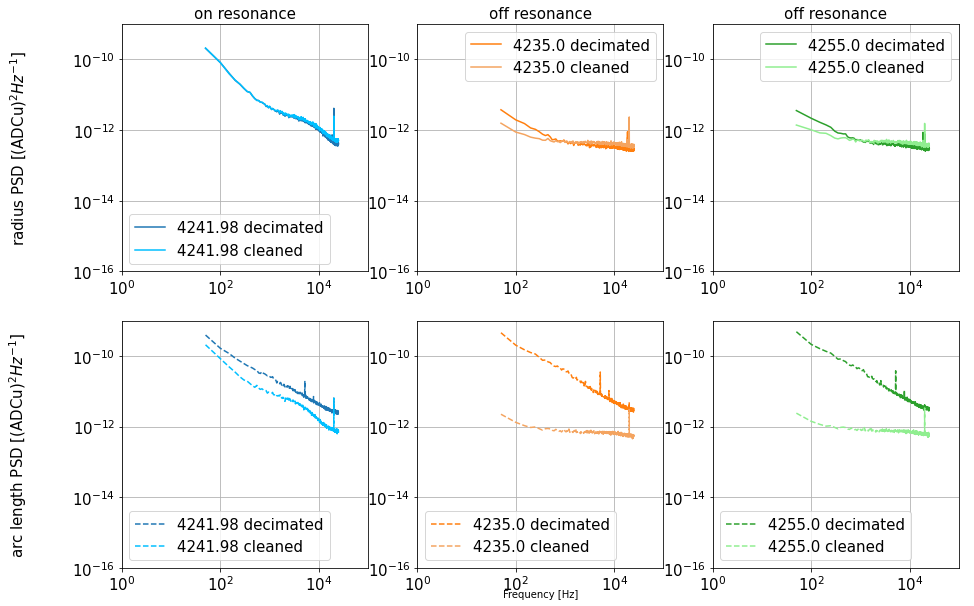

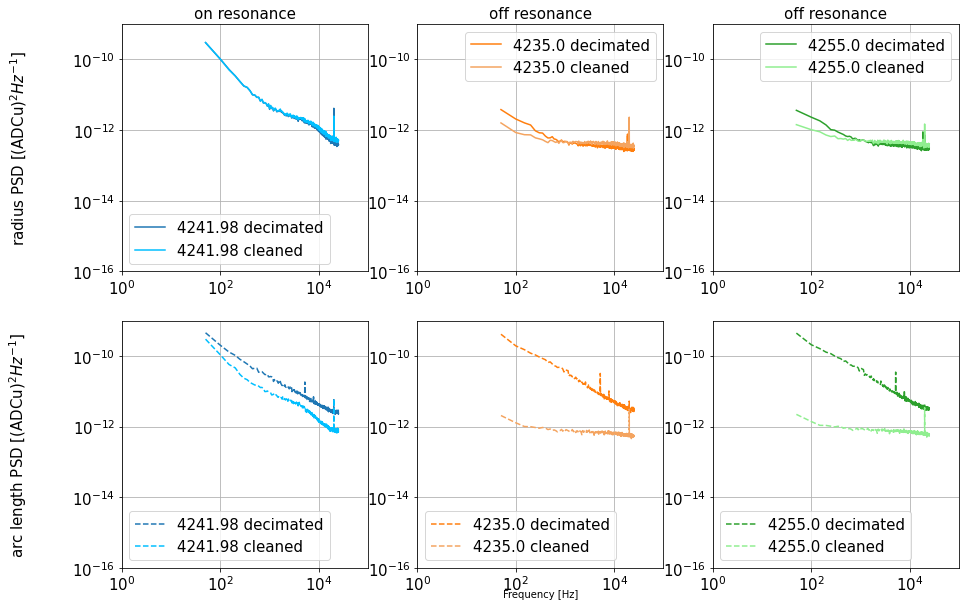

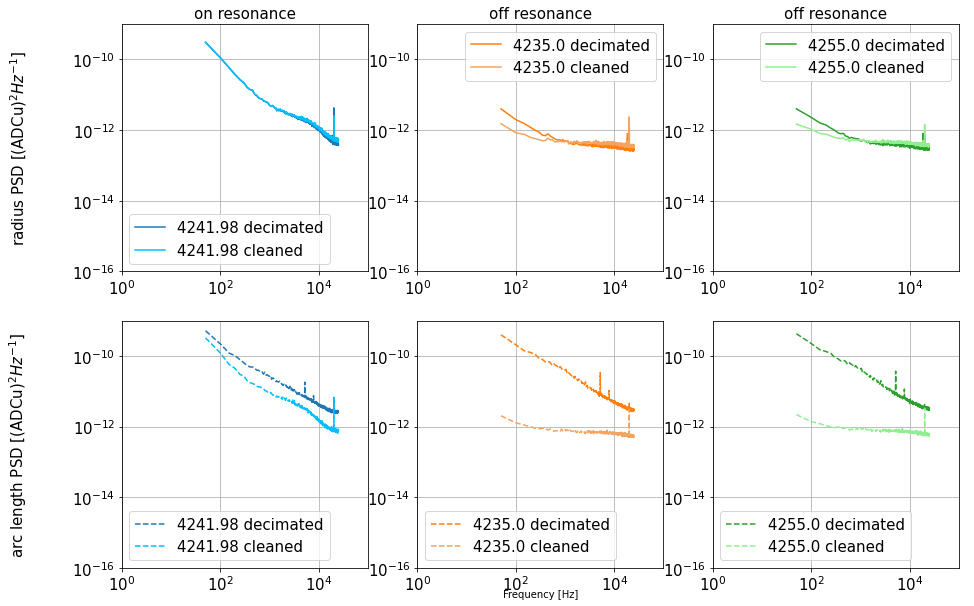

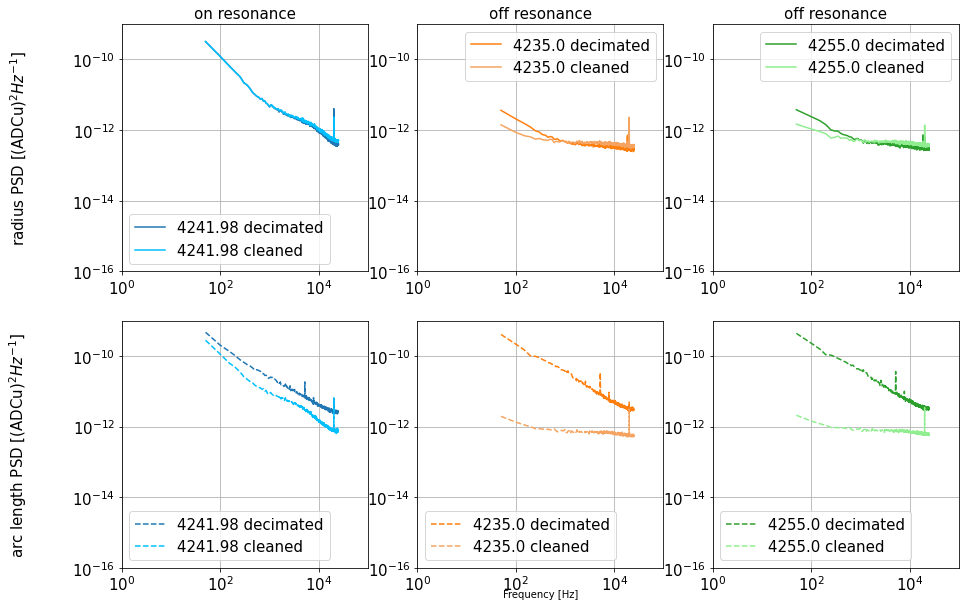

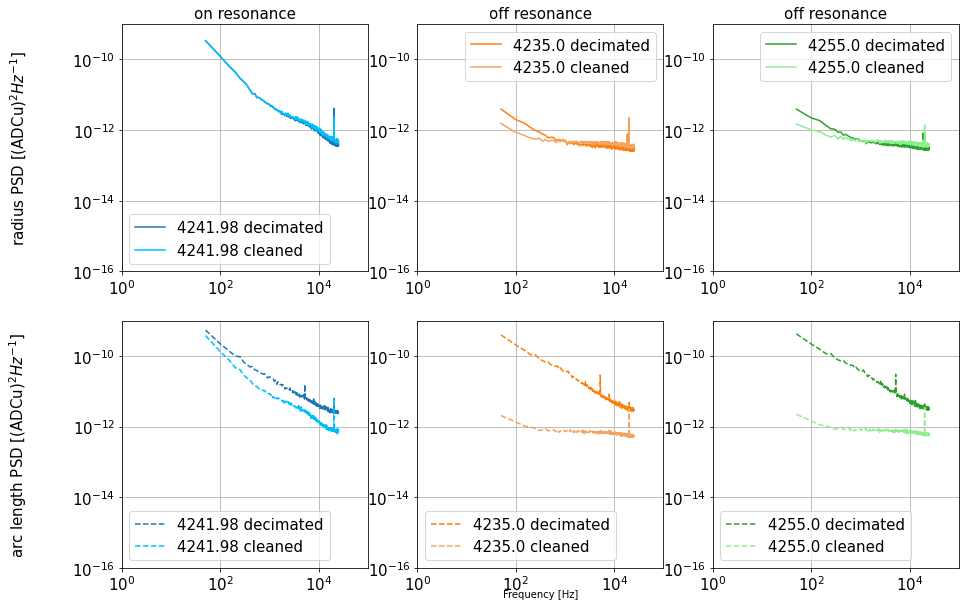

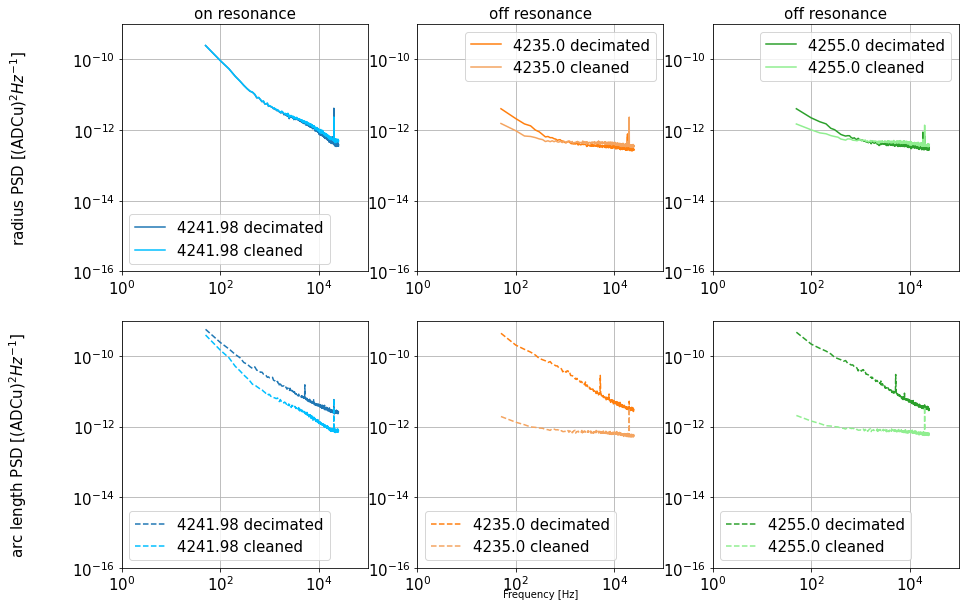

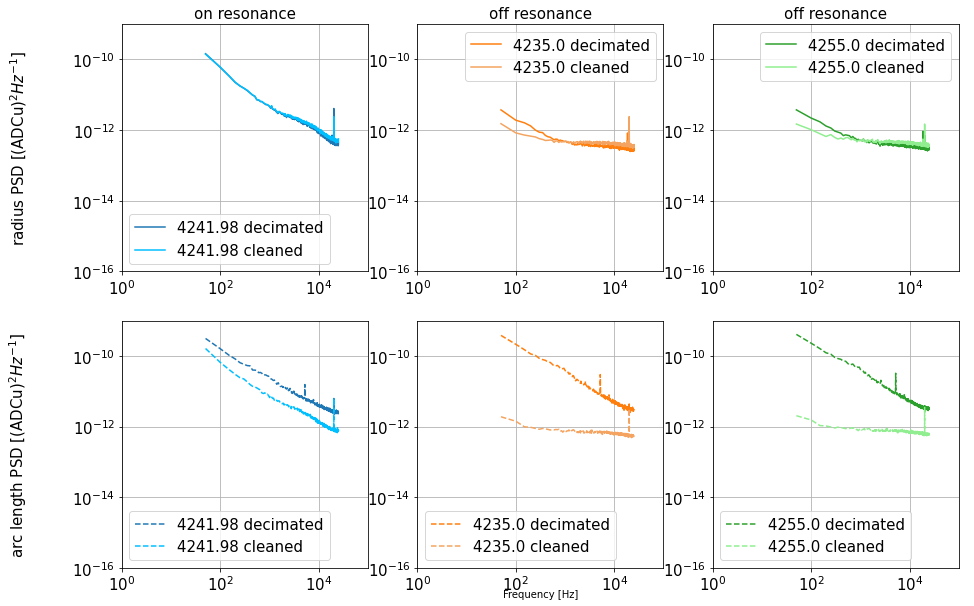

In [18]:
## Options
show_plots = False
verbose    = False 

## Window selection for pulse-free region
window_shift_seconds = 0 # -8.0e-3
frac_to_keep = 0.1 # was 0.1?

## Select the noise file to use
noise_indx = 0
noise_file = nse_files[noise_indx]
    
## We will need these cleaned noise timestreams later
_, _, _, timestreams = Thf.CleanPSDs(noise_file, vna_file, 
    PSD_lo_f=chunk_up_to, 
    PSD_hi_f=decimate_down_to, 
    rem_dec=10,
    f_transient=blank_fraction, 
    charFs=charFs[noise_indx].real, 
    charZs=charZs[noise_indx],show_plots=False, verbose=False)

j = 0
for pulse_file in LED_files:
    print('===================')
    print('cleaning pulse file:',pulse_file)
    print('using VNA file:     ',vna_file)
    print('using noise file:   ',noise_file)
    
    ## Create plots to store waveforms
    ## ========================================================================
    if show_plots:
        fi0 = plt.figure(pulse_file+"_a")
        ax0 = fi0.gca()
        ax0.set_xlabel("Time [ms]")
        ax0.set_ylabel(r"$\log_{10}|S_{21}|$")
        ax0.set_title(".".join(pulse_file.split("/")[-1].split(".")[0:-1]))
        
        fi1 = plt.figure(pulse_file+"_b")
        ax1 = fi1.gca()
        ax1.set_xlabel(r"$\Re(S_{21})$")
        ax1.set_ylabel(r"$\Im(S_{21})$")
        ax1.set_title(".".join(pulse_file.split("/")[-1].split(".")[0:-1]))
    ## ========================================================================

    ## Determine how much additional decimation to apply
    pulse_noise, pulse_info = PUf.unavg_noi(pulse_file)
    pulse_fs = 1./pulse_info['sampling period']
    pulse_cleaning_decimation = int(np.round(pulse_fs/decimate_down_to))

    if verbose:
        print('loaded pulse data')

    ## Get the decimated timestream and frequency step
    pulse_noise = Prf.average_decimate(pulse_noise,pulse_cleaning_decimation)
    pulse_fs   /= pulse_cleaning_decimation

    if verbose:
        print('decimated data by ' + str(pulse_cleaning_decimation) + ' to achieve requested upper bound of ' + '{:2e}'.format(decimate_down_to) + ' Hz' )

    ## Create a new array of of frequency space with the applied decimation
    sampling_rate = pulse_fs
    samples_per_pulse = int(time_btw_pulse*sampling_rate)
    N = int(frac_to_keep * samples_per_pulse) ## We look at the second half of a pulse window only
    T = N/sampling_rate
    t,f = Prf.build_t_and_f(N,sampling_rate)
    time = 1e3*(time_btw_pulse-t[::-1])
    
    if verbose:
        print("Sampling rate:",sampling_rate,"per sec")
        print("Samples per pulse window:",samples_per_pulse)
        print("N=:",N,"; T=",T,";",np.shape(f))
    
    ## Define the regions where pulses exist
    ## =====================================
    
    ## This defines where (in # of pulse windows) to start looking for pulses
    pulse_start = int(total_pulses * blank_fraction)
    if verbose:
        print("Starting pulse partitioning after", pulse_start, "windows (of",total_pulses,")")
    
    ## How many samples to shift the pulse window definition
    window_shift = int(window_shift_seconds * sampling_rate)
    if verbose:
        print("Shifting pulse window by", window_shift, "samples")
    
    ## Create empty arrays to store our results in
    noise_averages = np.zeros((3),dtype=np.complex128)
    J_r = np.zeros((N,3)); J_arc = np.zeros((N,3))
    
    ## Create empty arrays to store values for histograms
    bl_means = np.array([],dtype=np.complex128)
    bl_sdevs = np.array([])#,dtype=np.complex128)
    
    ## Count how many good pulses there are
    n_good_pulses = num_pulses - len(bad_pls_idxs[pulse_file])
    
    ## Start the loop over pulse windows
    k=0
    for pulse_i in range(pulse_start,int(total_pulses),1):
        
        ## Skip the bad pulse windows
        if k in bad_pls_idxs[pulse_file]:
            ## Increment the counter
            k += 1
            continue
        
        ## Define the sample index where this pulse window ends
        pulse_i_end = int((pulse_i+1)*samples_per_pulse)
        
        ## Define the start of the pulse free region (period after pulse, before the next one, where it should be baseline noise)
        no_pulse_idx_start = pulse_i_end + window_shift - N 
        
        ## Define the end of the window (where the pulse-free region ends)
        no_pulse_idx_end   = pulse_i_end + window_shift
        
        ## Grab the timestream in that region and average it
        no_pulse_chunk = pulse_noise[no_pulse_idx_start:no_pulse_idx_end,:]
        
        ## Calculate some means and stdevs of this pulse-free timestream
        m = np.mean(no_pulse_chunk,axis=0,dtype=np.complex128) ; bl_means = np.append(bl_means,m[0])
        
        if PHASE:
            s = np.std( np.angle(    no_pulse_chunk[:,0])  ) ; bl_sdevs = np.append(bl_sdevs,s)
        else:
            s = np.std( np.log10(abs(no_pulse_chunk[:,0])) ) ; bl_sdevs = np.append(bl_sdevs,s)
        
        ## Keep a running average of the noise across all pulse regions
        noise_averages += m / n_good_pulses    
        
        ## Plot the pulse free region against time
        if show_plots: # and (k==0):
            ax0.plot(time, np.log10(abs(no_pulse_chunk[:,0])),alpha=0.25)
            ax1.scatter(no_pulse_chunk[:,0].real,no_pulse_chunk[:,0].imag,alpha=0.25)

        ## Convert to the electronics basis and compute the J objects
        r_chunk,arc_chunk,_,_= Prf.electronics_basis(no_pulse_chunk)
        J_r += abs(Prf.discrete_FT(r_chunk))**2 / n_good_pulses * 2 * T
        J_arc += abs(Prf.discrete_FT(arc_chunk))**2 / n_good_pulses * 2 * T
        
        ## Increment the counter
        k += 1
    
    if verbose:
        print("Searched",n_good_pulses,"pulse windows")
        print('used ' + str(n_good_pulses) + ' chunks to find quiescent point')
    
    ## Create plots to store histograms
    ## ========================================================================
    if show_plots:
        ax0.axhline(y=np.log10(abs(noise_averages[0])),color="k",ls='--')
        
        fi2 = plt.figure(pulse_file+"_c")
        ax2 = fi2.gca()
        if PHASE:
            ax2.hist(np.angle(bl_means))
            ax2.set_xlabel(r"Pre-trigger BL mean $\arg(S_{21})$")
        else:
            ax2.hist(np.log10(abs(bl_means)))
            ax2.set_xlabel(r"Pre-trigger BL mean $\log_{10}(|S_{21}|)$")
        ax2.set_ylabel("Occurences")
        ax2.set_title(".".join(pulse_file.split("/")[-1].split(".")[0:-1]))
        
        fi3 = plt.figure(pulse_file+"_d")
        ax3 = fi3.gca()
        if PHASE:
            ax3.hist(bl_sdevs)
            ax3.set_xlabel(r"Pre-trigger BL sdev $\arg(S_{21})$")
        else:
            ax3.hist(bl_sdevs)
            ax3.set_xlabel(r"Pre-trigger BL sdev $\log_{10}(|S_{21}|)$")
        ax3.set_ylabel("Occurences")
        ax3.set_title(".".join(pulse_file.split("/")[-1].split(".")[0:-1]))
    ## ========================================================================

    ## Pull the two real quantities from the complex timestream averages
    radius_averages = abs(noise_averages)
    angle_averages  = np.angle(noise_averages)
    if verbose:
        print(radius_averages)
        print(angle_averages)

    ## Rotate the timestream by the averange angle, then get the rotated phase timestream
    pulse_timestream_rotated = pulse_noise*np.exp(-1j*angle_averages)
    angle_timestream = np.angle(pulse_timestream_rotated)

    ## Subtract off the average magnitude value and calculate an arc length
    radius = abs(pulse_noise) - radius_averages
    arc    = angle_timestream*radius_averages

    ## Create output containers for the clean timestreams
    radius_clean = np.zeros(radius.shape)
    arc_clean    = np.zeros(arc.shape)

    if verbose:
        print('built radius and arc length timestreams given by quiescent point')
        print(noise_file)
        
    ## Pull the dictionary containing cleaning coefficients from the noise timestream
    _,data_info = PUf.clean_noi(noise_file[:-3]+'_cleaned.h5')

    ## Loop over each tone in the radius timestream
    for t in range(radius.shape[1]):
        ## Pull the coefficients from the noise cleaning
        radius_coefficient = data_info['radius cleaning coefficient'][t]
        arc_coefficient    = data_info['arc cleaning coefficient'][t]

        ## Clean each tone with the off-resonance tones
        if t == 0:
            off_tone_idcs = [1,2]
        elif t == 1:
            off_tone_idcs = [2]
        elif t == 2:
            off_tone_idcs = [1]

        ## Perform the radius cleaning
        off_tone_radius = np.mean(radius[:,off_tone_idcs],axis=1,dtype=np.float64)
        radius_clean[:,t] = radius[:,t] - radius_coefficient*off_tone_radius

        ## Perform the arc length cleaning
        off_tone_arc = np.mean(arc[:,off_tone_idcs],axis=1,dtype=np.float64)
        arc_clean[:,t] = arc[:,t] - arc_coefficient*off_tone_arc

        if verbose: 
            print('cleaned tone ' + str(t))

    ## Subtract off the mean from cleaned radius and arc length timestreams
    radius_clean -= np.mean(radius_clean,axis=0,dtype='float64')
    arc_clean -= np.mean(arc_clean,axis=0,dtype='float64')
    
    ## Save the clean timestreams to a file
    pulse_noise_clean = Prf.save_clean_timestreams(pulse_file,\
                                                   radius_averages,\
                                                   angle_averages,\
                                                   radius_clean,\
                                                   arc_clean,\
                                                   sampling_rate,\
                                                   timestreams['radius coefficient'],\
                                                   timestreams['arc coefficient'],\
                                                   override=True)

    ## Calculate the PSDs for each of the cleaned pulses
    ## ========================================================================
    
    ## Create containers for our output PSDs
    J_r_clean = np.zeros((N,3)); J_arc_clean = np.zeros((N,3))
    
    ## Loop over pulses
    k = 0
    for pulse_i in range(pulse_start,int(total_pulses),1):
        ## Skip the bad pulse windows
        if k in bad_pls_idxs[pulse_file]:
            ## Increment the counter
            k += 1
            continue
        
        ## Define the sample index where this pulse window ends
        pulse_i_end = int((pulse_i+1)*samples_per_pulse) 
        
        ## Define the start of the pulse free region (period after pulse, before the next one, where it should be baseline noise)
        no_pulse_idx_start = pulse_i_end + window_shift - N 
        
        ## Define the end of the window (where the pulse-free region ends)
        no_pulse_idx_end   = pulse_i_end + window_shift
        
        ## Grab the timestream in that region
        no_pulse_chunk = pulse_noise_clean[no_pulse_idx_start:no_pulse_idx_end,:]

        ## Convert the pulse-free region to electronics basis
        r_chunk,arc_chunk,_,_= Prf.electronics_basis(no_pulse_chunk)
        
        ## Compute the PSDs
        J_r_clean += abs(Prf.discrete_FT(r_chunk))**2 / n_good_pulses * 2 * T
        J_arc_clean += abs(Prf.discrete_FT(arc_chunk))**2 / n_good_pulses * 2 * T
        
        ## Increment the counter
        k += 1

    ## Trim the output to the positive frequency region only
    J_r = J_r[f>=0]; J_r_clean = J_r_clean[f>=0]; J_arc = J_arc[f>=0]; J_arc_clean = J_arc_clean[f>=0]
    
    ## Every tenth files, show the PSDs
    if j % 1 == 0:
        print(pulse_file)
        fig_0, axes_0 = plt.subplots(2,3,sharex=True,sharey='row',figsize=(5*3,10))
        
        Prf.plot_PSDs(f[f>0],J_r,J_arc,pulse_file,\
                      ['radius','arc length'],units=['ADCu','ADCu'],savefig='electronics',\
                      data_freqs=pulse_info['search freqs'],\
                      P_1_clean=J_r_clean,P_2_clean=J_arc_clean,\
                      fig_0=fig_0,axes_0=axes_0)

    j += 1

## Pulse averaging

averaging pulse file: /data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_2.000V_20230215_101743.h5
Used 323 pulses to average
averaging pulse file: /data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_2.500V_20230215_101743.h5
Used 305 pulses to average
averaging pulse file: /data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_3.000V_20230215_101743.h5
Used 348 pulses to average
averaging pulse file: /data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_3.500V_20230215_101743.h5
Used 341 pulses to average
averaging pulse file: /data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_4.000V_20230215_101743.h5
Used 343 pulses to average
averaging pulse file: /data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_4.500V_20230215_101743.h5
Used 483 pulses to average
averaging pulse file: /data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_5.000V_20230215_101743.h5
Used 371 pulses to average


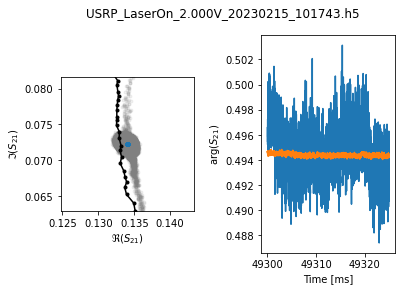

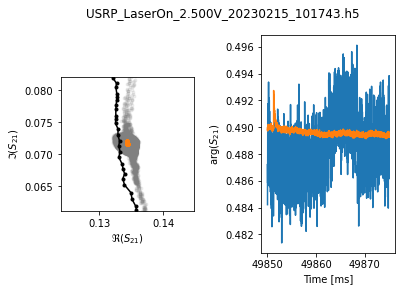

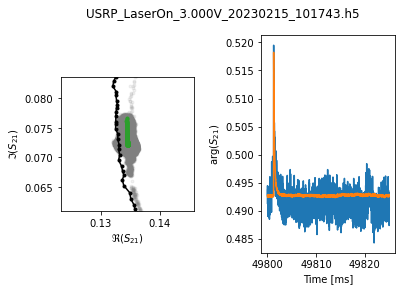

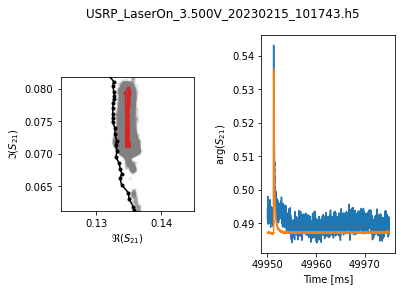

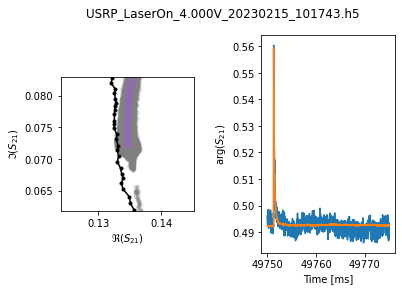

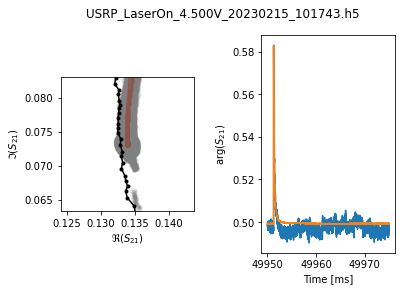

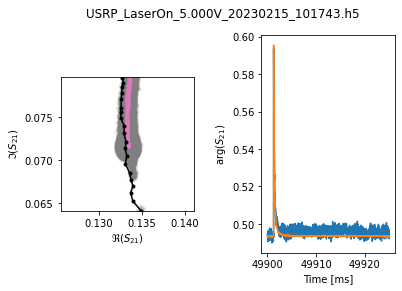

In [19]:
fraction_to_keep = 0.5 # 1.0 # 0.5 # (5.0/12.5) # 1.0
window_shift_seconds = 0 # 5.0e-3
verbose = False

j = 0 
for pulse_file in LED_files:
    
    ## Get the VNA data for this set of runs
    f,z = PUf.read_vna(vna_file)

    print('===================')
    print('averaging pulse file: ' + pulse_file)

    ## Load the clean pulse data
    clean_pulse_file = pulse_file[:-3] + '_cleaned.h5'
    pulse_noise_clean,data_info = PUf.clean_noi(clean_pulse_file)
    if verbose: 
        print('loaded clean pulse data')        
        print('sampling_rate: ' + str(data_info['sampling_rate']))
    
    ## Determine how many samples are in each pulse window
    samples_per_pulse = data_info['sampling_rate'] * time_btw_pulse

    ## Do extra decimation if needed (1 = no decimation) 
    decimation = 1
    time = Prf.average_decimate(pulse_info['time'],decimation)
    pulse_noise_clean = Prf.average_decimate(pulse_noise_clean,decimation)
    
    ## Update the samples per window and sampling rate with new decimation
    samples_per_pulse_decimated = int(samples_per_pulse / decimation)
    sampling_rate = data_info['sampling_rate'] / decimation
    if verbose:
        print('further decimation by ' + str(decimation) + ' complete')

    ## Create a container to store our average pulse in complex S21 for this file
    pulse_avg    = np.zeros(int(samples_per_pulse_decimated*fraction_to_keep),dtype=np.complex128)
    
    ## Determine how many samples to shift the window by
    window_shift = int(window_shift_seconds*sampling_rate)
    
    ## Identify the first pulse window after the transient period
    pulse_start  = int(total_pulses * blank_fraction)
    
    ## Count how many good pulses there are in this file
    n_good_pulses = num_pulses - len(bad_pls_idxs[pulse_file])
    
    ## Start the loop over pulse windows
    k=0
    for pulse_i in range(pulse_start,int(total_pulses),1):
        
        ## Skip the bad pulse windows
        if k in bad_pls_idxs[pulse_file]:
            ## Increment the counter
            k += 1
            continue

        ## Define the sample index where this pulse window ends
        pulse_idx_start = int((pulse_i  )*samples_per_pulse_decimated) + window_shift
        # pulse_idx_end   = int((pulse_i+1)*samples_per_pulse_decimated) + window_shift -1
        pulse_idx_end   = int(round((pulse_i+fraction_to_keep)*samples_per_pulse_decimated,0)) + window_shift
        
        ## Create a list of indeces corresponding to the samples in this pulse window
        pulse_idx_list = np.arange(pulse_idx_start,pulse_idx_end,1,dtype=int)
        
        ## Average the pulses in each good window
        pulse_avg += pulse_noise_clean[pulse_idx_list,0] / n_good_pulses
        
        ## Increment the counter
        k += 1
    
    ## Create a figure in complex S21 to show VNA, full timestream, and average pulse
    fig, axs = plt.subplots(1, 2)
    plt.suptitle(pulse_file.split("/")[-1])
    axs[0].set_xlabel(r"$\Re(S_{21})$")
    axs[0].set_ylabel(r"$\Im(S_{21})$")
    axs[1].set_xlabel("Time [ms]")
    if PHASE:
        axs[1].set_ylabel(r"$\arg (S_{21})$")
    else:
        axs[1].set_ylabel(r"$\log10 |S_{21}|$")
    
    axs[0].plot(pulse_noise_clean[:,0].real,pulse_noise_clean[:,0].imag,ls='',marker='.',alpha=0.1,color='grey')
    axs[0].plot(pulse_avg.real,pulse_avg.imag,color='C'+str(j % 10),ls='-',marker='.')
    axs[0].plot(z.real,z.imag,color='k',ls='-',marker='.',alpha=1.00)
    
    if PHASE:
        axs[1].plot(time[pulse_idx_list,0]*1e3,np.angle(pulse_noise_clean[pulse_idx_list,0]))
        axs[1].plot(time[pulse_idx_list,0]*1e3,np.angle(pulse_avg))
    else:
        axs[1].plot(time[pulse_idx_list,0]*1e3,np.log10(abs(pulse_noise_clean[pulse_idx_list,0])))
        axs[1].plot(time[pulse_idx_list,0]*1e3,np.log10(abs(pulse_avg)))
    
    width = 50 * np.std(pulse_noise_clean[:,0].real)
    x_c = np.mean(pulse_avg.real)
    y_c = np.mean(pulse_avg.imag)
    axs[0].set_xlim([x_c - width/2., x_c + width/2.])
    axs[0].set_ylim([y_c - width/2., y_c + width/2.])
    axs[0].set_aspect('equal','box')
    
    plt.subplots_adjust(wspace=0.5)
    
    # plt.savefig('noise and averaged pulse.png',dpi=100)
        
    print('Used ' + str(n_good_pulses) + ' pulses to average')
    with h5py.File(clean_pulse_file, "a") as fyle:
        if 'pulse_shape' in fyle.keys():
            del fyle['pulse_shape']
            print('deleted an old pulse shape')
        fyle.create_dataset('pulse_shape',data = np.asarray(pulse_avg))
    j += 1

## Pulse rotation

In [20]:
# %matplotlib notebook
## Create a colormap for plotting different LED powers
cmap   = plt.get_cmap('OrRd')

# plt.rcParams.update({'font.size': 18})

In [ ]:
## Initialize an index to count files as we loop
i = 0

## Define the time window for the pulse-full region, in microseconds
time_window_range = fraction_to_keep * time_btw_pulse *1e6
time_window = np.arange(0,time_window_range,1/sampling_rate*1e6)#[:-1]

## Define the time window in microseconds that will be used to align the pulses later
tw_min =  8000 # 200 # 3000 # 
tw_max = 10000 # 300 # 4000 # 
# time_window = np.arange(-200,time_window_range-200,1/sampling_rate*1e6)
# time_window = np.arange(window_shift_seconds*1e6,time_window_range+window_shift_seconds*1e6,1/sampling_rate*1e6)

## Create some strings to use as plot titles and handles later
AWF_string = str(int(10*pulse_w)/10) + " us"
title_1    = 'power ' + str(rf_power) + '; AWF ' + AWF_string + ': pulses in S21'
title_1p5  = 'power ' + str(rf_power) + '; AWF ' + AWF_string + ': pulses in S21, zoomed in'
title_1p75 = 'alignment of pulses using largest pulse (blue)' 
# title_2    = 'S_21 pulse height along pulse alignment axis'
title_2    = 'Average Pulse Shapes'

## Pull the readout frequency from the characterization data
## then get the VNA data for this run
readout_f = charFs[0,1].real
f,z = PUf.read_vna(vna_file)

## Loop over the full list of LED files (the reversed order is no longer important)
for pulse_file in LED_files[::-1]:
    print('===================')
    print('cleaning pulse file:',pulse_file)
    print('using VNA file:     ',vna_file)
    print('using summary file: ',sum_file)
    char_file = sum_file

    ## Get the cleaned data and average pulse
    clean_pulse_file = pulse_file[:-3] + '_cleaned.h5'
    with h5py.File(clean_pulse_file, "r") as fyle:
        pulse_avg = np.array(fyle["pulse_shape"],dtype=np.complex128)
        pulse_timestream = np.array(fyle["cleaned_data"],dtype=np.complex128)

    ## Get the timestreams and average pulse in resonator basis
    df_f, d1_Q, _, _ = Prf.resonator_basis(pulse_avg,readout_f*1e-3,f*1e-3,z,charFs[0].real*1e-3,charZs[0])#,plot_title='power ' + power_directories[j][:-1] + ' AWF ' + AWF_string)
    df_f_timestream, d1_Q_timestream, _, _ = Prf.resonator_basis(pulse_timestream[:,0],readout_f*1e-3,f*1e-3,z,charFs[0].real*1e-3,charZs[0])
    # plt.axis([0.058, 0.062, -0.19, -0.15])
    
    ## Get the timestreams and average pulse in quasiparticle basis
    dk1, dk2, =                       Prf.quasiparticle_basis(df_f, d1_Q,
                                                              data_T     = 10.0e-3, 
                                                              MB_results = MB_fit_vals,
                                                              readout_f  = readout_f*1e-3)
    dk1_timestream, dk2_timestream, = Prf.quasiparticle_basis(df_f_timestream, d1_Q_timestream,
                                                              data_T     = 10.0e-3, 
                                                              MB_results = MB_fit_vals,
                                                              readout_f  = readout_f*1e-3)

    ## Baseline(mean)-subtract the average pulse, then find its stdev
    ## Using the last five samples of the average pulse to get mean, sdev
    pulse_avg_mb = pulse_avg - np.mean(pulse_avg[-5:],dtype=np.complex128)
    std = np.std(abs(pulse_avg_mb[-5:]),dtype=np.complex128)
    
    ## Calculate the average angle of the average pulse in the specified alignment window
    average_angle = np.mean(np.angle(pulse_avg_mb[np.logical_and(time_window>tw_min,time_window<tw_max)]))
    
    ## Baseline(mean)-subtract the (raw) pulse timestream for the on-resonance tone
    ## Again using the last five samples of the average pulse to get mean
    pulse_timestream_mb = pulse_timestream[:,0] - np.mean(pulse_avg[-5:],dtype=np.complex128)

    ## Apply the rotation by the average angle to the baseline-subtracted timestream and average pulse
    pulse_avg_rotated = pulse_avg_mb * np.exp(-1j*average_angle)
    pulse_timestream_rotated = pulse_timestream_mb * np.exp(-1j*average_angle)

    ## Define the pulse template we want to use and which timestream to use it on
    ## Also subtract the baseline of the template to make sure baseline=0 for optimal filtering
    
    ## == CHOOSE ONE TO DO ANALYSIS == ##
    
    ## Fractional change in frequency 
    template = df_f - np.mean(df_f[:20])
    noise = df_f_timestream - np.mean(df_f[:20])
    ylbl  = r"Frequency Shift $\delta f / f$"

    ## Dissipation direction quasiparticle basis
#     template = dk2 - np.mean(dk2[:20])
#     noise = dk2_timestream - np.mean(dk2[:20])
#     ylbl  = r"Dissipation qp shift $\delta \kappa_2$ [$\mu$m$^{-3}$]"

    # template = pulse_avg_rotated.real
    # noise = pulse_timestream_rotated.real
    # print(np.shape(pulse_avg),np.shape(df_f))

    ## Open the clean data file and save the template and noise
    with h5py.File(clean_pulse_file, "a") as fyle:
        print("Saving clean pulse file:",clean_pulse_file)
        if 'df_f_template' in fyle.keys():
            del fyle['df_f_template']
        if 'df_f_pulse_noise' in fyle.keys():
            del fyle['df_f_pulse_noise']
        fyle.create_dataset('df_f_template',data = np.asarray(template))
        fyle.create_dataset('df_f_pulse_noise',data = np.asarray(noise))
    
    ## Define some labels to add to plots
    label_c = 'characterization data' if i == 0 else None
    label_V = 'VNA' if i == 0 else None
    label_p = 'pulse data ' if i == 0 else None
    
    ## Grab the vna + average pulse plot, draw the vna, average pulse, and characterization data
    ## we only have to draw the VNA on the first file
    plt.figure(title_1)
    plt.title(title_1)
    plt.plot(pulse_avg.real,pulse_avg.imag,ls='-',marker='.',markersize=5,color='C'+str(i%10))
    # plt.plot(pulse_timestream[4:,0].real,pulse_timestream[4:,0].imag,ls='None',marker='.',color='C'+str(i%10),alpha=0.1)
    if i==0:
        plt.plot(z.real,z.imag,color='k',label=label_V)
    plt.plot(charZs.real,charZs.imag,marker='*',markersize=10,ls='-',label=label_c,zorder=-5*i+200)
    plt.axhline(0,color='grey')
    plt.axvline(0,color='grey')
    
    ## Adjust the plot limits
    width = np.std(pulse_avg.real) * 8e3
    x_c = np.mean(pulse_avg.real)
    y_c = np.mean(pulse_avg.imag)
    plt.axis([x_c - width/2., x_c + width/2., y_c-width/2., y_c+width/2.])
    plt.gca().set_aspect('equal','box')
    plt.legend()

    ## Grab the zoomed-in vna + average pulse plot, draw the vna, average pulse, and characterization data
    ## we only have to draw the VNA on the first file
    plt.figure(title_1p5)
    plt.title(title_1p5)
    plt.plot(pulse_avg.real,pulse_avg.imag,ls='-',marker='.',markersize=5,color='C'+str(i%10),label=label_p,zorder=-5*i+200)
    # if i==7:
    #     plt.plot(pulse_avg.real,pulse_avg.imag,ls='-',marker='.',markersize=5,color='k',label=label_p,zorder=-5*i+200)
    #     plt.plot(pulse_timestream[:,0].real,pulse_timestream[:,0].imag,ls='None',marker='.',color='C'+str(i%10),alpha=0.01)
    if i==0:
        plt.plot(z.real,z.imag,color='k',label=label_V)
    # plt.plot(charZs.real,charZs.imag,marker='*',markersize=10,ls='',label=label_c,zorder=-5*i+200)
    
    ## Use the first file to set the extent of the zoomed-in plot
    if i == 0:
        width = 150 * np.std(pulse_avg.real)
        x_c = np.mean(pulse_avg.real)
        y_c = np.mean(pulse_avg.imag)
        plt.axis([x_c - width/2., x_c + width/2., y_c-width/2., y_c+width/2.])

    ## Grab the average pulse rotation plot
    plt.figure(title_1p75)
    plt.title(title_1p75)
    plt.plot(pulse_avg_rotated.real,pulse_avg_rotated.imag,ls='-',marker='.',markersize=5,color='C'+str(i%10))
    plt.gca().set_aspect('equal', 'box')
    
    ## Grab the average pulse timestream plot and draw the timestream of the average pulse
    plt.figure(title_2)
#     plt.xlabel('microseconds')
    plt.xlabel('milliseconds')
    plt.ylabel(ylbl)
    plt.title(title_2)
    plt.plot(time_window/1e3,template,ls='-',marker=None,markersize=5,label=str(Voltages[::-1][i])+" V",color=cmap( (Voltages[::-1][i]-1.5) / (np.max(Voltages)-1.5) ))#'C'+str(i))

    ## Increment our file counter
    i += 1
    
## Grab the zoomed-in vna + average pulse plot
plt.figure(title_1p5)

## Loop over the noise files again
for ai in np.arange(len(nse_files)):
    ## Get the noise timestream and average
    frequencies_scanned, noise_mean_scanned = PUf.avg_noi(nse_files[ai],time_threshold=30.0*blank_fraction)
    ## Draw the points
    plt.plot(noise_mean_scanned[0].real,noise_mean_scanned[0].imag,marker='*',markersize=10,markeredgecolor='k',ls='None',color='y',zorder=-5*i+200,alpha=ai*.2,label="Noise Averages")

plt.legend()

plt.figure(title_2)
plt.legend(loc='best')

cleaning pulse file: /data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_5.000V_20230215_101743.h5
using VNA file:      /data/USRP_Laser_Data/20230215/20230215_101743/USRP_VNA_20230215_101743.h5
using summary file:  /data/USRP_Laser_Data/20230215/20230215_101743/noise_averages_20230215_101743.h5
Fr from fit  [GHz]: 4.241979856975336
Fr min curve [GHz]: 4.241979948819871
Fr from fit  [GHz]: 4.241979856975336
Fr min curve [GHz]: 4.241979948819871
Saving clean pulse file: /data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_5.000V_20230215_101743_cleaned.h5
cleaning pulse file: /data/USRP_Laser_Data/20230215/20230215_101743/USRP_LaserOn_4.500V_20230215_101743.h5
using VNA file:      /data/USRP_Laser_Data/20230215/20230215_101743/USRP_VNA_20230215_101743.h5
using summary file:  /data/USRP_Laser_Data/20230215/20230215_101743/noise_averages_20230215_101743.h5
Fr from fit  [GHz]: 4.241979856975336
Fr min curve [GHz]: 4.241979948819871
Fr from fit  [GHz]: 4.241979856975336
Fr mi

## Optimal Filter code

### OF Window parameter definitions

In [ ]:
## Number of seconds by which to shift the window when calculating J
window_shift_J = 0 # -8.0e-3 # -10e-6 #

## Define a maximum frequency for the fourier-space mask
f_max = 1e4 ## Hz maximum freq in fourier space

## Create titles for the plots
title      = 'readout power ' + str(rf_power) + ': '

## Create a colormap for plotting different LED powers
cmap   = plt.get_cmap('OrRd')

### Determine the signal template

In [ ]:
use_fit_as_template = False

## Pick the highest LED voltage data to use as signal template
pls_file_template = LED_files[-1]
print("Using file:",pls_file_template,"as pulse template")

## Find the clean pulse file, use the last one in the set that's been analyzed so far
clean_pulse_file = pls_file_template[:-3] + '_cleaned.h5'

## Open the cleaned data and pull the data sampling rate, pulse template, and pulse noise
with h5py.File(clean_pulse_file, "r") as fyle:
    sampling_rate = np.array(fyle['sampling_rate'])
    pulse_avg     = np.array(fyle["df_f_template"])

## Determine a window size equivalent to the full pulse template window
N = len(pulse_avg)
print(N, "samples per window")

## Determine total period of the template and create a time-domain array and a freq-domain array
T = N/sampling_rate
time, f = Prf.build_t_and_f(N,sampling_rate)

## Define an offset function to recenter the pulse
t_offset = lambda N: int( (delay_ms*1e-3) * sampling_rate)
# t_offset = lambda N: int(N * (2*delay_ms*1e-3/time_btw_pulse) / frac_to_keep)

## Define an exponential function
exponential = lambda x, A, tau: np.heaviside(x-time[t_offset(N)],0.5) * A * expit(-1*(x-time[t_offset(N)])/tau)
dbl_expA    = lambda x, A, t1, t2: np.heaviside(x-time[t_offset(N)],0.5) * A * ( expit(-1*(x-time[t_offset(N)])/t1) + expit(-1*(x-time[t_offset(N)])/t2) )
# dbl_expB    = lambda x, A1, A2, t1, t2: np.heaviside(x-time[t_offset(N)],0.5) * ( A1*np.exp(-1*(x-time[t_offset(N)])/t1) + A2*np.exp(-1*(x-time[t_offset(N)])/t2) )

# ## Fit the average pulse to an exponential (in df/f)
# popt, pcov  = curve_fit(exponential,time,pulse_avg,p0=[5.0e-7,       1.24e-3])
# popt2,pcov2 = curve_fit(dbl_expA,time,pulse_avg   ,p0=[5.0e-7,       1.24e-3/5.,1.24e-3*5.])
# # popt3,pcov3 = curve_fit(dbl_expB,time,pulse_avg   ,p0=[2.5e-7,2.5e-7,1.24e-3/5.,1.24e-3*5.])
# # Aweights = ( popt3[0]/(popt3[0]+popt3[1]) , popt3[1]/(popt3[0]+popt3[1]) )
# # print(weights)

## Fit the average pulse to an exponential (in k2)
popt, pcov  = curve_fit(exponential,time,pulse_avg,p0=[5.0,       1.24e-3])
popt2,pcov2 = curve_fit(dbl_expA,time,pulse_avg   ,p0=[5.0,       1.24e-3/5.,1.24e-3*5.])
    
## Calculate the best fit curve for the average pulse
pulse_fit  = exponential(time,*popt)
pulse_fit2 = dbl_expA(time,*popt2)
# pulse_fit3 = dbl_expB(time,*popt3)
    
## Get the frequency space of the average pulse
# s_temp = Prf.discrete_FT(pulse_avg)

# ## Normalize the pulse average
# pulse_avg = pulse_avg / np.max(pulse_avg)
    
## Numerically integrate the fit, then FT it
if use_fit_as_template:   
    A = np.trapz(pulse_fit,dx = time[1]-time[0])
    s = Prf.discrete_FT(pulse_fit)
else:
    A = np.trapz(pulse_avg,dx = time[1]-time[0])
    s = Prf.discrete_FT(pulse_avg)

## Define a mask for evaluating fourier space components
f_mask = np.logical_and(f <= f_max, f >= -1*f_max)
N_mask = len(f[f_mask])
f_plot = np.logical_and(f > 0, f <= f_max)
new_fs = max(f[f_mask])

## Get the magnitude of s^2 for the masked region
S_mag = abs(s[f_mask]**2)

## Create a plot to store the template waveform and best fit
f1p5  = plt.figure()
ax1p5 = f1p5.gca()
ax1p5.plot(time*1e3,pulse_fit, 'C7',linewidth=3,label='time constant: {:.2e}ms'.format(popt[-1]*1e3), ls='--' )
# ax1p5.plot(time*1e3,pulse_fit3,'C6',linewidth=3,label='Float weights\n'+r'$\tau_1=$ {:.2e}ms'.format(popt3[-2]*1e3)+"\n"+r'$\tau_2=$ {:.2e}ms'.format(popt3[-1]*1e3))
ax1p5.plot(time*1e3,pulse_fit2,'k' ,linewidth=1,label='Equal weights\n'+r'$\tau_1=$ {:.2e}ms'.format(popt2[-2]*1e3)+"\n"+r'$\tau_2=$ {:.2e}ms'.format(popt2[-1]*1e3))
ax1p5.plot(time*1e3,pulse_avg, label="Average pulse")
ax1p5.axhline(y=0,color='r',ls='--')
ax1p5.set_title(title + 'signal pulse timestream and fit')
ax1p5.set_xlabel("Time [ms]")
ax1p5.set_ylabel(ylbl)
# ax1p5.set_ylabel(r"Dissipation $\delta \kappa_2$ [$\mu$m$^{-3}$]")
plt.legend()

f1p7  = plt.figure()
ax1p7 = f1p7.gca()
ax1p7.plot(time*1e3,pulse_fit -pulse_avg,'C7',linewidth=3,label=r'$\tau=$ {:.2e}ms'.format(popt[-1]*1e3) , ls='--' )
# ax1p7.plot(time*1e3,pulse_fit3-pulse_avg,'C6',linewidth=3,label='Float weights\n'+r'$\tau_1=$ {:.2e}ms'.format(popt3[-2]*1e3)+"\n"+r'$\tau_2=$ {:.2e}ms'.format(popt3[-1]*1e3))
ax1p7.plot(time*1e3,pulse_fit2-pulse_avg,'k' ,linewidth=1,label='Equal weights\n'+r'$\tau_1=$ {:.2e}ms'.format(popt2[-2]*1e3)+"\n"+r'$\tau_2=$ {:.2e}ms'.format(popt2[-1]*1e3))
ax1p7.axhline(y=0,color='r',ls='--')
ax1p7.set_title(title + 'fit residuals')
ax1p7.set_xlabel("Time [ms]")
ax1p7.set_ylabel("Fit residual")
plt.legend()

### Determine the noise template

In [ ]:
## Pick the lowest LED voltage data to use as noise template
nse_file_template = LED_files[0]
print("Using file:",nse_file_template,"to characterize noise")

## Find the clean noise file, use the last one in the set that's been analyzed so far
clean_noise_file = nse_file_template[:-3] + '_cleaned.h5'

## Open the cleaned data and pull the data sampling rate, pulse template, and pulse noise
with h5py.File(clean_noise_file, "r") as fyle:
    sampling_rate = np.array(fyle['sampling_rate'])          
    pulse_noise   = np.array(fyle["df_f_pulse_noise"])

## Determine total period of the template and create a time-domain array and a freq-domain array
T = N/sampling_rate
time, f = Prf.build_t_and_f(N,sampling_rate)

## Determine how many samples to shift the window when calculating J
samples_per_pulse  = sampling_rate*time_btw_pulse
window_shift_J_idx = int(window_shift_J*sampling_rate)
    
## Create a container to store J in temporarily
J = np.zeros(N)
    
## Count how many good pulses there are in this file
n_good_pulses = num_pulses - len(bad_pls_idxs[pulse_file])

## Loop over all the pulse windows in the file
## We want to skip the windows cut out when finding noise free region
k = 0
for pulse_i in range(pulse_start,int(total_pulses),1):

    ## Skip the bad pulse windows
    if k in bad_pls_idxs[pulse_file]:
        ## Increment the counter
        k += 1
        continue

    ## Find the index for the end of this pulse window
    pulse_i_end = int((pulse_i+1)*samples_per_pulse) 

    ## Apply the window shift and an array of samples for the window timestream points
    ## Are we really trying to find a pulse free region? seems like it
    no_pulse_idx_start = pulse_i_end + window_shift_J_idx - N
    no_pulse_idx_end   = pulse_i_end + window_shift_J_idx
    no_pulse_idx_list  = np.arange(no_pulse_idx_start,no_pulse_idx_end,1,dtype=int)
    no_pulse_noise_i   = pulse_noise[no_pulse_idx_list]

    ## Caclulate the average J for this region
    J += abs(Prf.discrete_FT(no_pulse_noise_i))**2 / n_good_pulses * 2 * T

    ## Increment the counter
    k += 1
    
## Determine the average J for plotting
J_avg = np.mean(J)

## Calculate the denominator for the optimal filter
denominator = np.sum(abs(s[f_mask])**2/J[f_mask])

## Calculate the baseline resolution
b7_res = np.sqrt(((2*T*denominator)**-1))
print("Baseline resolution:", b7_res)

## Plot the J we'll use for optimal filtering
f2p0  = plt.figure()
ax2p0 = f2p0.gca()
plt.plot(f[f_plot],J[f_plot],zorder=-5*j+5,color='k')
ax2p0.set_title(title + 'noise frequency domain')
ax2p0.set_xlabel("Frequency [Hz]")
ax2p0.set_ylabel(r"$J$")
ax2p0.set_xscale('log')
ax2p0.set_yscale('log')
ax2p0.set_ylim([1e-1*J_avg,5e2*J_avg])

### Run the optimal filter

In [ ]:
## Create an empty dataframe for the pulse amplitudes and prepare to save it to a file
f_name = series+"_OF_pulse_amps.h5"
f_path = os.path.join(datapath,f_name)

ampl_data = pd.DataFrame()
fit_data  = pd.DataFrame()
fit_errs  = pd.DataFrame()
sum_data  = pd.DataFrame()
max_data  = pd.DataFrame()
sum_errs  = pd.DataFrame()
max_errs  = pd.DataFrame()

In [ ]:
verbose = False
# plt.rcParams.update({'font.size': 32})

## Create titles for the plots
title      = r'$P_g=$' + str(rf_power-line_atten_dB) + ' dBm: '
title_1    = title + 'signal template'
title_2    = title + 'noise power spectral density'
title_2    = 'noise power spectral densities'
title_2p2  = 'noise power spectral densities at lowest F'
title_2p1  = 'examples of V in time'
title_2p5  = 'index of IFFT with peak value'
title_3    = title + 'OF Pulse Amplitudes'
title_3p5  = title + 'cdf of pulse heights'
title_4    = title #+ 'sigma vs mu'
title_5    = title + 'residuals'

plt.figure(title_3, figsize=(14,4.5))
plt.figure(title_4, figsize=(14,5))
plt.figure(title_5, figsize=(14,5))

## Something to do about time offset between pulse window and singal template
offset_exponent = np.zeros((N_mask,N_mask),dtype=np.complex128)
time_ds = np.linspace(0,(N_mask-2)/(2*new_fs),N_mask)
print((N_mask-1)/(2*new_fs))
for j in range(N_mask):
    offset_exponent[j,:] = np.exp(1j*2*np.pi*f[f_mask][j]*time_ds)

for j in range(N_mask):
    for k in range(N_mask):
        if abs(offset_exponent[j,k].real) < 1e-10:
            offset_exponent[j,k] = 1j*offset_exponent[j,k].imag
        if abs(offset_exponent[j,k].imag) < 1e-10:
            offset_exponent[j,k] = offset_exponent[j,k].real

## Containers for ...
mu    = np.zeros(N_mask)
sigma = np.zeros(N_mask)

mu_err    = np.zeros(N_mask)
sigma_err = np.zeros(N_mask)

## Create containers to hold the means and standard deviations for the pulse height distribution
## for each of the pulse files
mus    = []
sigmas = []
J_at_min_f = np.array([])

## Start a loop over pulse files
j = 0
for pulse_file in LED_files[::-1]:
    if verbose: 
        print('=====================')
        print('analyzing data file: ' + pulse_file, "VLED=",Voltages[::-1][i])
    
#     color = cmap( (Voltages[::-1][j]-np.min(Voltages)) / (np.max(Voltages)-np.min(Voltages)) ) # 'C'+str(j%10)
    color = cmap( (Voltages[::-1][j]-1.5) / (np.max(Voltages)-1.5) ) # 'C'+str(j%10)
    
    ## Pull the average pulse and pulse PSDs from the cleaned pulse data file
    clean_pulse_file = pulse_file[:-3] + '_cleaned.h5'
    with h5py.File(clean_pulse_file, "r") as fyle:
        pulse_avg = np.array(fyle["df_f_template"])            
        pulse_noise = np.array(fyle["df_f_pulse_noise"])

    ## Recenter the average pulse
    pulse_recentered = pulse_avg # np.concatenate((pulse_avg[t_offset(N):],pulse_avg[:t_offset(N)]))
    
    ## Fit the average pulse to an exponential
    popt,pcov = curve_fit(exponential,time,pulse_recentered,p0=[1.2e-4,50e-6])
    
    ## Calculate the best fit curve for the average pulse
    pulse_fit = exponential(time,*popt)
    
    ## Get the frequency space of the average pulse
    s_temp = Prf.discrete_FT(pulse_recentered)
    
    ## Create a plot and store the signal template in f-space
    if j == 0:
        plt.figure(title_1)
        plt.plot(f[f_plot],abs(s[f_plot]**2),zorder=-5*j+5,color='k',linewidth=3)
        
    ## Focus the plot already containing the signal template, draw the average pulse for this file
    plt.figure(title_1)
    plt.plot(f[f_plot],abs(s_temp[f_plot]**2),zorder=-5*j+5,color=color)

    ## Determine how many samples to shift the window when calculating J
    samples_per_pulse  = sampling_rate*time_btw_pulse
    window_shift_J_idx = int(window_shift_J*sampling_rate)
    
    ## Create a container to store J in temporarily
    J_temp = np.zeros(N)
    
    ## Count how many good pulses there are in this file
    n_good_pulses = num_pulses - len(bad_pls_idxs[pulse_file])

    ## Loop over all the pulse windows in the file
    ## Do we want to skip the windows cut out when finding average pulse? probably
    k = 0
    for pulse_i in range(pulse_start,int(total_pulses),1):
        
        ## Skip the bad pulse windows
        if k in bad_pls_idxs[pulse_file]:
            ## Increment the counter
            k += 1
            continue
        
        ## Find the index for the end of this pulse window
        pulse_i_end = int((pulse_i+1)*samples_per_pulse) 
        
        ## Apply the window shift and an array of samples for the window timestream points
        ## Are we really trying to find a pulse free region? seems like it
        no_pulse_idx_start = pulse_i_end + window_shift_J_idx - N
        no_pulse_idx_end   = pulse_i_end + window_shift_J_idx
        no_pulse_idx_list  = np.arange(no_pulse_idx_start,no_pulse_idx_end,1,dtype=int)
        no_pulse_noise_i   = pulse_noise[no_pulse_idx_list]
        
        ## Caclulate the average J for thid region
        J_temp += abs(Prf.discrete_FT(no_pulse_noise_i))**2 / n_good_pulses * 2 * T
        # J_temp += abs(fft.ifft(no_pulse_noise_i))**2 / num_pulses * 2 * T
        
        ## Increment the counter
        k += 1
        
    ## Plot the average J for this pulse file
    plt.figure(title_2)
    plt.plot(f[f_plot],J_temp[f_plot],zorder=-5*j+5,color=color)
    plt.plot(f[f_plot],J[f_plot],zorder=-5*j+5,color="k")
    
    plt.figure(title_2p2)
    plt.scatter(Voltages[::-1][j],J_temp[f_plot][0],zorder=-5*j+5,color=color)
    J_at_min_f = np.append(J_at_min_f, J_temp[f_plot][0])
#     plt.plot(f[f_plot],J_temp[f_plot],zorder=-5*j+5,color=('k' if j==0 else color))

    ## Create containers for our output related to pulse height
    ## One entry for every pulse window, not using cuts on baseline
    A_hat     = np.zeros((n_good_pulses,N_mask))
    A_max_idx = np.zeros(n_good_pulses)
    A_hat_max = np.zeros(n_good_pulses)
    A_hat_sum = np.zeros(n_good_pulses)
    
    ## Not sure that we want to apply an offset because of how we did things earlier?
    ## We want the rising edge of the pulse centered
    t_offset_idx = 0 # t_offset(N_mask) # 
    
    ## Initialize a counter and loop over every pulse window
    ## Again, do we want to skip the regions we cut earlier? probably not
    k = 0 ; jj = 0
    for pulse_i in range(pulse_start,int(total_pulses),1):
        
        ## Skip the bad pulse windows
        if k in bad_pls_idxs[pulse_file]:
            ## Increment the counter
            k += 1
            continue
        
        ## Apply the window shift and an array of samples for the window timestream points
        ## This is the same window shift defined in the pulse averaging code block
        pulse_i_start   = int(pulse_i*samples_per_pulse)
        pulse_idx_start = pulse_i_start + window_shift
        pulse_idx_end   = pulse_idx_start + N
        pulse_idx_list  = np.arange(pulse_idx_start,pulse_idx_end,1,dtype=int)
        pulse_noise_i   = pulse_noise[pulse_idx_list]
        
        # pulse_noise_i_recentered = np.concatenate((pulse_noise_i[N//2:],pulse_noise_i[:N//2]))

        ## Fourier transform the baseline-subtracted window
        v = Prf.discrete_FT(pulse_noise_i - np.mean(pulse_noise_i[:20])) 
#         v = Prf.discrete_FT(pulse_noise_i - np.mean(pulse_noise_i[-5:])) 
        
        ## Apply the window shift and an array of samples for the window timestream points
        ## for the pulse free region
        pulse_i_end        = int((pulse_i+1)*samples_per_pulse) 
        no_pulse_idx_start = pulse_i_end + window_shift_J_idx - N 
        no_pulse_idx_end   = pulse_i_end + window_shift_J_idx
        no_pulse_idx_list  = np.arange(no_pulse_idx_start,no_pulse_idx_end,1,dtype=int)
        no_pulse_noise_i   = pulse_noise[no_pulse_idx_list]
        
        ## Fourier transform the baseline-subtracted pulse-free window
        v_noise = Prf.discrete_FT(no_pulse_noise_i - np.mean(no_pulse_noise_i[:20]))

        ## Plot some number of pulses in the template pulse file
        if j == 0 and (pulse_i + 0) % 20 == 0:
            plt.figure(title_2p1)
            plt.plot(time*1e3,pulse_noise_i,alpha=0.3)#color='k')

        ## Calculate the numerator of the optimal filter 
        numerator = Prf.discrete_IFT(np.conj(s[f_mask])*v[f_mask]/J[f_mask])
        numerator = numerator.real

        ## Calculate the sum in the numerator of the optimal filter
        numerator_sum = sum(offset_exponent[:,t_offset_idx]*np.conj(s[f_mask])*v_noise[f_mask]/J[f_mask])
        numerator_sum = numerator_sum.real
      
        ## Find the maximum of the optimal filter numerator
        max_numerator = max(numerator)
        max_idx = np.argwhere(numerator == max_numerator)

        ## Calculate the optimal filter
        A_max_idx[jj] = max_idx 
        A_hat[jj,:]   = numerator / denominator
        A_hat_max[jj] = max_numerator/denominator
        A_hat_sum[jj] = numerator_sum / denominator
        
        ## Increment the counter
        k += 1 ; jj += 1
        
    ## Loop over the points in the mask and fit the OF to a gaussian, extracting the mean and sigma
    for fp in range(N_mask):
        popt_p, perr_p,  _  = fit_samples_to_gauss_unbinned(A_hat[:,fp])
        (mu[fp], sigma[fp]) = popt_p
        (mu_err[fp], sigma_err[fp]) = perr_p
    
    ## If we are on the template file define the optimal t0 for the pulse
    optimal_t0 = t_offset_idx
        
    ## fit the OF max and sum to a gaussian, extracting the mean and sigma   
    popt_max, perr_max, _ = fit_samples_to_gauss_unbinned(A_hat_max)
    (mu_max   , sigma_max   ) = popt_max
    (mu_max_uc, sigma_max_uc) = perr_max
    
    popt_sum, perr_sum, _ = fit_samples_to_gauss_unbinned(A_hat_sum)
    (mu_sum   , sigma_sum   ) = popt_sum
    (mu_sum_uc, sigma_sum_uc) = perr_sum
    
    ## Print the mean and sigma from the OF fit
    print('mu = ' + "{:.2e}".format(mu[t_offset_idx]) + '; sigma = ' + "{:.2e}".format(sigma[t_offset_idx])+ '; sigma_0 = ' + "{:.3e}".format(b7_res))         

    ## Draw the histograms of maximum amplitude index in the FFT spectra
    plt.figure(title_2p5)
    n, bins, patches = plt.hist(A_max_idx,bins=N,fill=False,histtype='step',label='radians',color=color)
        
    if (j+0) % 1 == 0: # True: # 
        # print(LED_files[j])
        
        ## Get the current array of optimal pulse heights
        data = A_hat[:,optimal_t0]
        nbins = 20 # 100
        
        ## Save this data to the dataframes
        data_filled = -999*np.ones(1000)
        data_filled[:len(data)] = data
        
        ampl_data[str(Voltages[::-1][j])] = data_filled
        fit_data[ str(Voltages[::-1][j])] = np.array([mu[optimal_t0],sigma[optimal_t0]])
        fit_errs[ str(Voltages[::-1][j])] = np.array([mu_err[optimal_t0],sigma_err[optimal_t0]])
        sum_data[ str(Voltages[::-1][j])] = np.array([mu_sum,sigma_sum])
        max_data[ str(Voltages[::-1][j])] = np.array([mu_max,sigma_max])
        sum_errs[ str(Voltages[::-1][j])] = np.array([mu_sum_uc,sigma_sum_uc])
        max_errs[ str(Voltages[::-1][j])] = np.array([mu_max_uc,sigma_max_uc])
        
        ## Create the histograms of pulse heights and draw fits
        plt.figure(title_3)
        if j == 0:
            n, bins, patches = plt.hist(data,bins=nbins,fill=False,histtype='step',label='radians',color=color,density=1.0)
            bin_width = bins[1]-bins[0]
        else:
            n, bins, patches = plt.hist(data,bins=np.arange(min(data), max(data) + bin_width, bin_width),fill=False,histtype='step',label='radians',color=color,density=1.0)
            
        plt.plot(np.linspace(bins[0],bins[-1],100),\
                 norm.pdf(np.linspace(bins[0],bins[-1],100),mu[optimal_t0],sigma[optimal_t0]),\
                 c='gray')
        
        ## Manipulate the data to compare CDFs
        data_sorted = np.sort(data)[2:-2]
        xdata = data_sorted - np.min(data_sorted)
        xdata = xdata/np.max(xdata)
        ydata = np.cumsum(xdata)/np.sum(xdata)
        
        ## Create the CDF plots
        plt.figure(title_3p5)
        plt.step(xdata,ydata,where='post',color=color)

    ## Write the fit results to the containers
    mus.append(mu[optimal_t0]); sigmas.append(sigma[optimal_t0])

    plt.figure(title_4)
    if j == 0:
        label1 = 'Triggering on signal'
        label2 = 'Triggering on noise'
    else:
        label1 = None
        label2 = None
    err_scale = 2
    plt.errorbar(mu[optimal_t0],sigma[optimal_t0],
                 xerr=err_scale*mu_err[optimal_t0],yerr=err_scale*sigma_err[optimal_t0],
                 color=color,ls=None,marker='.')
    plt.plot(mu[optimal_t0],sigma[optimal_t0],color=color,ls=None,marker='s',label=label1)
#     plt.plot(mu_sum,        sigma_sum,        color=color,ls=None,marker='s',label=label2,markersize=4,markeredgecolor='k')

    ## Increment the counter for pulse files
    j += 1

## Format the plots
plt.figure(title_1)
ax = plt.gca(); ax.set_yscale('log'); ax.set_xscale('log')
plt.title(title_1)

plt.figure(title_2)
ax = plt.gca(); ax.set_yscale('log'); ax.set_xscale('log')
J_avg = np.mean(J)
plt.ylim([1e-1*J_avg,1e2*J_avg])
plt.title(title_2)

plt.figure(title_2p1)
plt.title(title_2p1)
plt.xlabel("Time [ms]")

plt.figure(title_2p2)
plt.title(title_2p2)
plt.xlabel("LED Voltage [V]")
plt.ylabel(r"$J(f=f_\mathrm{min})$")

line = lambda x, m, b: m*x + b
min_fit_idx = 0

xdata = Voltages[::-1][:-3]
ydata = J_at_min_f[:-3]
print(xdata)
print(ydata)
popt, pcov = curve_fit( line , xdata, ydata, p0=[0.04, -0.04] ) # p0=[0.4e-19, -0.4e-19] )
plt.plot(Voltages, line(Voltages,popt[0],popt[1]), 'k-',label="Slope: "+str(popt[0]))
plt.legend(loc='best')

plt.figure(title_2p5)
plt.title(title_2p5)
plt.xlabel(r'index of IFFT($\frac{s^*v}{J}$)')

plt.figure(title_3)
plt.title(title_3)
plt.xlabel('Pulse Amplitude (normalized to tallest pulse)')
plt.ylabel('Density')
if False:
    ylim = plt.gca().get_ylim()
    plt.gca().set_yscale('log')
    plt.gca().set_ylim([1e0,ylim[1]])

plt.figure(title_3p5)
plt.title(title_3p5)
plt.xlabel('normalized pulse height range')
plt.ylabel('cumulative distribution')
plt.gca().set_ylim([-0.1,1.1])

plt.figure(title_4)
plt.title(title_4)
plt.axhline(b7_res,color='grey',label='Resolution from noise')
plt.xlabel('Pulse Amplitude (normalized to tallest pulse)'),#fontsize=18)
plt.ylabel('Distribution Width (normalized to tallest pulse)'),#fontsize=18)
# plt.xlabel(r'$\mu$')#,fontsize=18)
# plt.ylabel(r'$\sigma$')#,fontsize=18)
plt.tight_layout()

plt.figure()
print(sigma.shape)
for j in range(N_mask):
    plt.plot(np.mean(sigma,axis=0))
    plt.plot(optimal_t0,np.mean(sigma[optimal_t0]),ls='',marker='.',color='k')
# print(np.mean(np.mean(sigma[-8:])))
plt.xlabel('time offset')
plt.ylabel('OF noise')
plt.title('triggering on noise before pulse')
# plt.savefig('triggering_on_noise_after_pulse',dpi=300,facecolor='white',transparent=False)

def sig(mu,sigma_0,r):
    return np.sqrt(sigma_0**2 + (mu)*r)
#     return np.sqrt(b7_res**2 + (mu)*r)

def sig2(mu,sigma_0,r):
    return np.sqrt(b7_res**2 + (mu)*r)


mus = np.array(mus)
sigmas = np.array(sigmas)

# p0 = [1e-1,1e-9]
p0 = [1e-1,1e-2]
# f_fit_vals,_ = curve_fit(f,mu,sigma,p0,bounds=[(15*(0.008/2.6),7e-3),(40*(0.008/2.6),0.1)])
# f_fit_vals,_ = curve_fit(sig,mus[sigmas<0.035],sigmas[sigmas<0.035],p0)
f_fit_vals,_ = curve_fit(sig,mus,sigmas,p0)
print(np.max(sigma))
# f_fit_vals,_ = curve_fit(sig2,mu,[p0[1]])

sigma_0_E_pub = abs(f_fit_vals[0])/(f_fit_vals[1]/2.61)
# sigma_0_E_pub = abs(b7_res)/(f_fit_vals[1]/2.64)

print(b7_res)
# sigma_0_E_pub = abs(b7_res)/(f_fit_vals[1]/2.64)
print('energy resolution estimate is: ' + str(sigma_0_E_pub))
print(*f_fit_vals)

mu_plot = np.linspace(0,1.0,100)#5.5e-7,100)
plt.figure(title_4)
# plt.plot(mus,np.array(sigmas),ls=None) ## Blue connecting line
plt.plot(mu_plot,sig(mu_plot,*f_fit_vals),label='$\sigma_0$='+str(round(sigma_0_E_pub,1))+'eV')#,ls=None)
# plt.plot(mu_plot,sig2(mu_plot,*f_fit_vals),label='$\sigma_0$='+str(round(abs(b7_res)/(f_fit_vals[1]/2.61),1))+'eV')
# custom_lines = [\
#             #Line2D([0], [0],color='k',ls='',marker='.',label='max of IFT'),\
#             #Line2D([0], [0], color='k',alpha=0.5, ls='dashdot',label='radius and arc length directions'),\
#             Line2D([0], [0],color='k',ls='',marker='s',label='index 0'),]
#             #Line2D([0], [0], ls='',color='C1', marker='.',label='off resonance timestream')]
# #     plt.legend(handles=custom_lines)
plt.legend(loc='best',fontsize=20)
# plt.ylim([0,0.05])
# plt.gca().set_xlim([plt.gca().set_xlim()[0],1.1])
plt.tight_layout()
# plt.savefig('sigma_vs_mu.png',dpi=200)



plt.figure(title_5)
plt.title(title_5)

for jj in np.arange(len(LED_files)):
    xval = fit_data[str(Voltages[jj])][0]
    yval = fit_data[str(Voltages[jj])][1]
    xerr = fit_errs[str(Voltages[jj])][0]
    yerr = fit_errs[str(Voltages[jj])][1]
    fval = sig(xval, *f_fit_vals)
    yval = (yval-fval)/fval
    yerr = yerr/fval
    colr = cmap( (Voltages[jj]-1.5) / (np.max(Voltages)-1.5) )
    plt.errorbar(xval,yval,xerr=xerr,yerr=yerr,color=colr,marker='s',)
    plt.axhline(y=0,color='k',ls='--')

plt.xlabel('Pulse Amplitude (normalized to tallest pulse)'),#fontsize=18)
plt.ylabel('Fit fractional residuals')#,fontsize=18)
plt.tight_layout()


ampl_data.to_hdf(f_path,"data")
fit_data.to_hdf(f_path,"fit")
fit_errs.to_hdf(f_path,"fit err")
sum_data.to_hdf(f_path,"sum")
max_data.to_hdf(f_path,"max")
sum_errs.to_hdf(f_path,"sum err")
max_errs.to_hdf(f_path,"max err")

pd.DataFrame({"b7_res":np.array([b7_res])}).to_hdf(f_path,"b7_res")
pd.DataFrame({"r_fit":np.array([f_fit_vals[1]])}).to_hdf(f_path,"r_fit")